In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
CPI= pd.read_csv('CPI.csv', parse_dates=['YEAR'], index_col=['YEAR'])
gdp =pd.read_csv('GDP Current Prices IMF DATA.csv',parse_dates=['YEAR'], index_col=['YEAR'])

In [3]:
# Combine into one DataFrame
df_levels = pd.concat([CPI, gdp], axis=1)
df_levels.columns = ['CPI', 'gdp']
df_levels = df_levels.dropna()

In [4]:
 ##Johansen test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johansen_test = coint_johansen(df_levels, det_order=0, k_ar_diff=1)

# Trace statistic and critical values
print('Trace Statistic:\n', johansen_test.lr1)   # trace statistic
print('Critical values (90%, 95%, 99%):\n', johansen_test.cvt)

# Max eigenvalue statistic
print('Max-Eigen Statistic:\n', johansen_test.lr2)
print('Critical values (90%, 95%, 99%):\n', johansen_test.cvm)

Trace Statistic:
 [20.5916782   0.82261943]
Critical values (90%, 95%, 99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max-Eigen Statistic:
 [19.76905877  0.82261943]
Critical values (90%, 95%, 99%):
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [44]:
# Assuming gdp and cpi are already loaded with YEAR as index
df = pd.concat([gdp, CPI], axis=1)
df.columns = ["gdp", "CPI"]
df = df.dropna()
df.head()

# Split into train (up to 2008) and test
train0 = df.loc['2000-01-01':'2008-01-01']


In [45]:
df.head()


,gdp,CPI
YEAR,,
2000-01-01,11.340,4.475
2001-01-01,11.243,-37.198
2002-01-01,10.734,-34.445
2003-01-01,9.573,-8.565
2004-01-01,9.465,113.569


In [6]:
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model = VECM(train0, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res = vecm_model.fit()
print(vecm_res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -0.5862      0.291     -2.016      0.044      -1.156      -0.016
L1.CPI        -0.0008      0.001     -0.629      0.530      -0.003       0.002
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp       -75.5949     89.661     -0.843      0.399    -251.326     100.137
L1.CPI        -1.0922      0.416     -2.625      0.009      -1.908      -0.277
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [8]:
#Forecast 1 step ahead
forecast_1 = vecm_res.predict(steps=1)
gdp_forecast_2009 = forecast_1[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2009 = gdp.loc['2009-01-01'].values[0]
print("Forecasted GDP 2009:", gdp_forecast_2009)
print("Actual GDP 2009:", actual_gdp_2009)

# Forecast errors
mae = mean_absolute_error([actual_gdp_2009], [gdp_forecast_2009])
mse = mean_squared_error([actual_gdp_2009], [gdp_forecast_2009])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_gdp_2009 - gdp_forecast_2009) / actual_gdp_2009)) * 100

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)


Forecasted GDP 2009: 6.798333528834958
Actual GDP 2009: 9.666
MAE: 2.867666471165043
MSE: 8.223510989844169
RMSE: 2.867666471165043
MAPE: 29.667561257656143


In [9]:
# Forecast 3 steps ahead (2009, 2010, 2011)
forecast_3 = vecm_res.predict(steps=3)
gdp_forecasts = forecast_3[:, 0]  # GDP is column 0

gdp_2009, gdp_2010, gdp_2011 = gdp_forecasts

# Compare with actual 2011
actual_2011 = gdp.loc['2011-01-01'].values[0]

mae3 = mean_absolute_error([actual_2011], [gdp_2011])
mse3 = mean_squared_error([actual_2011], [gdp_2011])
rmse3 = np.sqrt(mse3)
mape3 = np.mean(np.abs((actual_2011 - gdp_2011) / actual_2011)) * 100

print("\n3-Step Ahead Forecast (GDP 2011):", gdp_2011)
print("Actual GDP 2011:", actual_2011)
print("MAE:", mae3, "RMSE:", rmse3, "MAPE:", mape3, 'MSE:', mse3)

# Forecast 4 steps ahead (2009–2012)
forecast_4 = vecm_res.predict(steps=4)
gdp_forecasts_4 = forecast_4[:, 0]

gdp_2012 = gdp_forecasts_4[-1]
actual_2012 = gdp.loc['2012-01-01'].values[0]

mae4 = mean_absolute_error([actual_2012], [gdp_2012])
mse4 = mean_squared_error([actual_2012], [gdp_2012])
rmse4 = np.sqrt(mse4)
mape4 = np.mean(np.abs((actual_2012 - gdp_2012) / actual_2012)) * 100

print("\n4-Step Ahead Forecast (GDP 2012):", gdp_2012)
print("Actual GDP 2012:", actual_2012)
print("MAE:", mae4, "RMSE:", rmse4, "MAPE:", mape4, 'MSE:', mse4)




3-Step Ahead Forecast (GDP 2011): 5.694520977833482
Actual GDP 2011: 14.102
MAE: 8.407479022166518 RMSE: 8.407479022166518 MAPE: 59.619054192075716 MSE: 70.68570350817006

4-Step Ahead Forecast (GDP 2012): 4.746944528144715
Actual GDP 2012: 17.115
MAE: 12.368055471855284 RMSE: 12.368055471855284 MAPE: 72.26441993488335 MSE: 152.96879615488942


In [10]:
# Split into train (up to 2008) and test
train1 = df.loc['2000-01-01':'2009-01-01']


In [11]:
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model1 = VECM(train1, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res1 = vecm_model1.fit()
print(vecm_res1.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -0.8056      0.513     -1.570      0.116      -1.811       0.200
L1.CPI         0.0012      0.003      0.330      0.742      -0.006       0.008
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp       -63.6218     59.784     -1.064      0.287    -180.797      53.553
L1.CPI        -1.0094      0.408     -2.477      0.013      -1.808      -0.211
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [12]:
#Forecast 1 step ahead
forecast02 = vecm_res1.predict(steps=1)
gdp_forecast_2010 = forecast02[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2010 = gdp.loc['2010-01-01'].values[0]
print("Forecasted GDP 2010:", gdp_forecast_2010)
print("Actual GDP 2010:", actual_gdp_2010)

# Forecast errors
mae1 = mean_absolute_error([actual_gdp_2010], [gdp_forecast_2010])
mse1 = mean_squared_error([actual_gdp_2010], [gdp_forecast_2010])
rmse1 = np.sqrt(mse1)
mape1 = np.mean(np.abs((actual_gdp_2010 - gdp_forecast_2010) / actual_gdp_2010)) * 100

print("MAE:", mae1)
print("MSE:", mse1)
print("RMSE:", rmse1)
print("MAPE:", mape1)


Forecasted GDP 2010: 6.27592254238799
Actual GDP 2010: 12.042
MAE: 5.76607745761201
MSE: 33.24764924718138
RMSE: 5.76607745761201
MAPE: 47.88305478834089


In [13]:
# Forecast 3 steps ahead (2009, 2010, 2011)
forecast03 = vecm_res1.predict(steps=3)
gdp_forecasts03 = forecast03[:, 0]  # GDP is column 0

gdp_2010, gdp_2011, gdp_2012 = gdp_forecasts

# Compare with actual 2011
actual_2012 = gdp.loc['2012-01-01'].values[0]

mae03 = mean_absolute_error([actual_2012], [gdp_2012])
mse03 = mean_squared_error([actual_2012], [gdp_2012])
rmse03 = np.sqrt(mse03)
mape03 = np.mean(np.abs((actual_2012 - gdp_2012) / actual_2012)) * 100

print("\n3-Step Ahead Forecast (GDP 2012):", gdp_2012)
print("Actual GDP 2012:", actual_2012)
print("MAE:", mae03, "RMSE:", rmse03, "MAPE:", mape03, 'MSE:', mse03)

# Forecast 4 steps ahead (2001-2013)
forecast04 = vecm_res1.predict(steps=4)
gdp_forecasts04 = forecast04[:, 0]

gdp_2013 = gdp_forecasts04[-1]
actual_2013 = gdp.loc['2013-01-01'].values[0]

mae04 = mean_absolute_error([actual_2013], [gdp_2013])
mse04 = mean_squared_error([actual_2013], [gdp_2013])
rmse04 = np.sqrt(mse04)
mape04 = np.mean(np.abs((actual_2013 - gdp_2013) / actual_2013)) * 100

print("\n4-Step Ahead Forecast (GDP 2013):", gdp_2013)
print("Actual GDP 2013:", actual_2013)
print("MAE:", mae04, "RMSE:", rmse04, "MAPE:", mape04, 'MSE:', mse04)




3-Step Ahead Forecast (GDP 2012): 5.694520977833482
Actual GDP 2012: 17.115
MAE: 11.420479022166516 RMSE: 11.420479022166516 MAPE: 66.72789379004685 MSE: 130.42734109574545

4-Step Ahead Forecast (GDP 2013): 5.701564110890251
Actual GDP 2013: 19.091
MAE: 13.38943588910975 RMSE: 13.38943588910975 MAPE: 70.13480639625871 MSE: 179.2769934285802


In [14]:
# Split into train (up to 2010) and test
train2 = df.loc['2000-01-01':'2010-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model2 = VECM(train2, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res2 = vecm_model2.fit()
print(vecm_res2.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         0.6915      0.465      1.486      0.137      -0.220       1.603
L1.CPI         0.0034      0.008      0.409      0.683      -0.013       0.020
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp       -12.4324     27.784     -0.447      0.655     -66.888      42.023
L1.CPI        -0.0684      0.492     -0.139      0.889      -1.032       0.896
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [15]:
#Forecast 1 step ahead
forecast03 = vecm_res2.predict(steps=1)
gdp_forecast_2011 = forecast03[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2011 = gdp.loc['2011-01-01'].values[0]
print("Forecasted GDP 2011:", gdp_forecast_2011)
print("Actual GDP 2011:", actual_gdp_2011)

# Forecast errors
mae2 = mean_absolute_error([actual_gdp_2011], [gdp_forecast_2011])
mse2 = mean_squared_error([actual_gdp_2011], [gdp_forecast_2011])
rmse2 = np.sqrt(mse2)
mape2 = np.mean(np.abs((actual_gdp_2011 - gdp_forecast_2011) / actual_gdp_2011)) * 100

print("MAE:", mae2)
print("MSE:", mse2)
print("RMSE:", rmse2)
print("MAPE:", mape2)

Forecasted GDP 2011: 13.80474629079793
Actual GDP 2011: 14.102
MAE: 0.29725370920207084
MSE: 0.0883597676343893
RMSE: 0.29725370920207084
MAPE: 2.10788334422118


In [16]:
# Forecast 3 steps ahead (2009, 2010, 2011)
forecast04 = vecm_res2.predict(steps=3)
gdp_forecasts04 = forecast04[:, 0]  # GDP is column 0

gdp_2011, gdp_2012, gdp_2013 = gdp_forecasts04

# Compare with actual 2011
actual_2013 = gdp.loc['2013-01-01'].values[0]

mae04 = mean_absolute_error([actual_2013], [gdp_2013])
mse04 = mean_squared_error([actual_2013], [gdp_2013])
rmse04 = np.sqrt(mse04)
mape04 = np.mean(np.abs((actual_2013 - gdp_2013) / actual_2013)) * 100

print("\n3-Step Ahead Forecast (GDP 2013):", gdp_2013)
print("Actual GDP 2013:", actual_2013)
print("MAE:", mae04, "RMSE:", rmse04, "MAPE:", mape04, 'MSE:', mse04)

# Forecast 4 steps ahead (2001-2014)
forecast05 = vecm_res2.predict(steps=4)
gdp_forecasts05 = forecast05[:, 0]

gdp_2014 = gdp_forecasts05[-1]
actual_2014 = gdp.loc['2014-01-01'].values[0]

mae05 = mean_absolute_error([actual_2014], [gdp_2014])
mse05 = mean_squared_error([actual_2014], [gdp_2014])
rmse05 = np.sqrt(mse05)
mape05 = np.mean(np.abs((actual_2014 - gdp_2014) / actual_2014)) * 100

print("\n4-Step Ahead Forecast (GDP 2014):", gdp_2014)
print("Actual GDP 2014:", actual_2014)
print("MAE:", mae05, "RMSE:", rmse05, "MAPE:", mape05, 'MSE:', mse05)




3-Step Ahead Forecast (GDP 2013): 15.265035015381535
Actual GDP 2013: 19.091
MAE: 3.825964984618466 RMSE: 3.825964984618466 MAPE: 20.040673535270365 MSE: 14.638008063526577

4-Step Ahead Forecast (GDP 2014): 15.604650991582456
Actual GDP 2014: 19.496
MAE: 3.891349008417542 RMSE: 3.891349008417542 MAPE: 19.95973024424263 MSE: 15.14259710531219


In [17]:
# Split into train (up to 2010) and test
train3 = df.loc['2000-01-01':'2011-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model3 = VECM(train3, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res3 = vecm_model3.fit()
print(vecm_res3.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         0.7815      0.314      2.490      0.013       0.166       1.397
L1.CPI         0.0048      0.007      0.722      0.470      -0.008       0.018
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         1.1399     18.674      0.061      0.951     -35.460      37.740
L1.CPI         0.1305      0.398      0.328      0.743      -0.649       0.910
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [18]:
#Forecast 1 step ahead
forecast05 = vecm_res3.predict(steps=1)
gdp_forecast_2012 = forecast05[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2012 = gdp.loc['2012-01-01'].values[0]
print("Forecasted GDP 2012:", gdp_forecast_2012)
print("Actual GDP 2012:", actual_gdp_2012)

# Forecast errors
mae7 = mean_absolute_error([actual_gdp_2012], [gdp_forecast_2012])
mse7 = mean_squared_error([actual_gdp_2012], [gdp_forecast_2012])
rmse7 = np.sqrt(mse7)
mape7 = np.mean(np.abs((actual_gdp_2012 - gdp_forecast_2012) / actual_gdp_2012)) * 100

print("MAE:", mae7)
print("MSE:", mse7)
print("RMSE:", rmse7)
print("MAPE:", mape7)

Forecasted GDP 2012: 15.91288531157764
Actual GDP 2012: 17.115
MAE: 1.202114688422359
MSE: 1.4450797241207853
RMSE: 1.202114688422359
MAPE: 7.023749275035694


In [19]:
# Forecast 3 steps ahead (2009, 2010, 2011)
forecast06 = vecm_res3.predict(steps=3)
gdp_forecasts06 = forecast06[:, 0]  # GDP is column 0

gdp_2012, gdp_2013, gdp_2014 = gdp_forecasts06

# Compare with actual 2011
actual_2014= gdp.loc['2014-01-01'].values[0]

mae06 = mean_absolute_error([actual_2014], [gdp_2014])
mse06 = mean_squared_error([actual_2014], [gdp_2014])
rmse06 = np.sqrt(mse06)
mape06 = np.mean(np.abs((actual_2014 - gdp_2014) / actual_2014)) * 100

print("\n3-Step Ahead Forecast (GDP 2014):", gdp_2014)
print("Actual GDP 2014:", actual_2014)
print("MAE:", mae06, "RMSE:", rmse06, "MAPE:", mape06, 'MSE:', mse06)

# Forecast 4 steps ahead (2001-2014)
forecast07 = vecm_res3.predict(steps=4)
gdp_forecasts07 = forecast07[:, 0]

gdp_2015 = gdp_forecasts07[-1]
actual_2015 = gdp.loc['2015-01-01'].values[0]

mae07 = mean_absolute_error([actual_2015], [gdp_2015])
mse07 = mean_squared_error([actual_2015], [gdp_2015])
rmse07 = np.sqrt(mse07)
mape07 = np.mean(np.abs((actual_2015 - gdp_2015) / actual_2015)) * 100

print("\n4-Step Ahead Forecast (GDP 2015):", gdp_2015)
print("Actual GDP 2015:", actual_2015)
print("MAE:", mae07, "RMSE:", rmse07, "MAPE:", mape07, 'MSE:', mse07)




3-Step Ahead Forecast (GDP 2014): 18.05124240033917
Actual GDP 2014: 19.496
MAE: 1.4447575996608286 RMSE: 1.4447575996608286 MAPE: 7.410533441017791 MSE: 2.087324521777719

4-Step Ahead Forecast (GDP 2015): 18.77974617044127
Actual GDP 2015: 19.963
MAE: 1.1832538295587298 RMSE: 1.1832538295587298 MAPE: 5.927234531677252 MSE: 1.4000896251653996


In [20]:
# Split into train (up to 2010) and test
train4 = df.loc['2000-01-01':'2012-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model4 = VECM(train4, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res4 = vecm_model4.fit()
print(vecm_res4.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         0.9478      0.284      3.338      0.001       0.391       1.504
L1.CPI         0.0066      0.007      0.991      0.321      -0.006       0.020
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         6.8454     16.268      0.421      0.674     -25.039      38.730
L1.CPI         0.1902      0.379      0.502      0.616      -0.552       0.933
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [21]:
#Forecast 1 step ahead
forecast08 = vecm_res4.predict(steps=1)
gdp_forecast_2013 = forecast08[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2013 = gdp.loc['2013-01-01'].values[0]
print("Forecasted GDP 2013:", gdp_forecast_2013)
print("Actual GDP 2013:", actual_gdp_2013)

# Forecast errors
mae8 = mean_absolute_error([actual_gdp_2013], [gdp_forecast_2013])
mse8 = mean_squared_error([actual_gdp_2013], [gdp_forecast_2013])
rmse8 = np.sqrt(mse8)
mape8 = np.mean(np.abs((actual_gdp_2013 - gdp_forecast_2013) / actual_gdp_2013)) * 100

print("MAE:", mae8)
print("MSE:", mse8)
print("RMSE:", rmse8)
print("MAPE:", mape8)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast09 = vecm_res4.predict(steps=3)
gdp_forecasts09 = forecast09[:, 0]  # GDP is column 0

gdp_2013, gdp_2014, gdp_2015 = gdp_forecasts09

# Compare with actual 2011
actual_2015= gdp.loc['2015-01-01'].values[0]

mae09 = mean_absolute_error([actual_2015], [gdp_2015])
mse09 = mean_squared_error([actual_2015], [gdp_2015])
rmse09 = np.sqrt(mse09)
mape09 = np.mean(np.abs((actual_2015 - gdp_2015) / actual_2015)) * 100

print("\n3-Step Ahead Forecast (GDP 2015):", gdp_2015)
print("Actual GDP 2015:", actual_2015)
print("MAE:", mae09, "RMSE:", rmse09, "MAPE:", mape09, 'MSE:', mse09)

# Forecast 4 steps ahead (2001-2014)
forecast10 = vecm_res4.predict(steps=4)
gdp_forecasts10 = forecast10[:, 0]

gdp_2016 = gdp_forecasts10[-1]
actual_2016 = gdp.loc['2016-01-01'].values[0]

mae10 = mean_absolute_error([actual_2016], [gdp_2016])
mse10 = mean_squared_error([actual_2016], [gdp_2016])
rmse10 = np.sqrt(mse10)
mape10 = np.mean(np.abs((actual_2016 - gdp_2016) / actual_2016)) * 100

print("\n4-Step Ahead Forecast (GDP 2016):", gdp_2016)
print("Actual GDP 2016:", actual_2016)
print("MAE:", mae10, "RMSE:", rmse10, "MAPE:", mape10, 'MSE:', mse10)



Forecasted GDP 2013: 20.232095053102444
Actual GDP 2013: 19.091
MAE: 1.1410950531024433
MSE: 1.302097920214868
RMSE: 1.1410950531024433
MAPE: 5.977136101317077

3-Step Ahead Forecast (GDP 2015): 25.291617154212048
Actual GDP 2015: 19.963
MAE: 5.328617154212047 RMSE: 5.328617154212047 MAPE: 26.692466834704437 MSE: 28.394160776162895

4-Step Ahead Forecast (GDP 2016): 27.61200249506048
Actual GDP 2016: 20.549
MAE: 7.063002495060481 RMSE: 7.063002495060481 MAPE: 34.371514404888224 MSE: 49.88600424523057


In [22]:
# Split into train (up to 2010) and test
train5 = df.loc['2000-01-01':'2013-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model5 = VECM(train5, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res5 = vecm_model5.fit()
print(vecm_res5.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         0.8375      0.190      4.418      0.000       0.466       1.209
L1.CPI         0.0045      0.005      0.834      0.404      -0.006       0.015
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -2.5201     11.214     -0.225      0.822     -24.499      19.459
L1.CPI         0.0377      0.321      0.118      0.906      -0.591       0.666
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [23]:
#Forecast 1 step ahead
forecast11 = vecm_res5.predict(steps=1)
gdp_forecast_2014 = forecast11[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2014 = gdp.loc['2014-01-01'].values[0]
print("Forecasted GDP 2014:", gdp_forecast_2014)
print("Actual GDP 2014:", actual_gdp_2014)

# Forecast errors
mae11 = mean_absolute_error([actual_gdp_2014], [gdp_forecast_2014])
mse11 = mean_squared_error([actual_gdp_2014], [gdp_forecast_2014])
rmse11 = np.sqrt(mse11)
mape11 = np.mean(np.abs((actual_gdp_2014 - gdp_forecast_2014) / actual_gdp_2014)) * 100

print("MAE:", mae11)
print("MSE:", mse11)
print("RMSE:", rmse11)
print("MAPE:", mape11)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast011 = vecm_res5.predict(steps=3)
gdp_forecasts011 = forecast011[:, 0]  # GDP is column 0

gdp_2014, gdp_2015, gdp_2016 = gdp_forecasts011

# Compare with actual 2011
actual_2016= gdp.loc['2016-01-01'].values[0]

mae011 = mean_absolute_error([actual_2016], [gdp_2016])
mse011 = mean_squared_error([actual_2016], [gdp_2016])
rmse011 = np.sqrt(mse011)
mape011 = np.mean(np.abs((actual_2016 - gdp_2016) / actual_2016)) * 100
print("\n3-Step Ahead Forecast (GDP 2016):", gdp_2016)
print("Actual GDP 2016:", actual_2016)
print("MAE:", mae011, "RMSE:", rmse011, "MAPE:", mape011, 'MSE:', mse011)

# Forecast 4 steps ahead (2001-2014)
forecast012 = vecm_res5.predict(steps=4)
gdp_forecasts012 = forecast012[:, 0]

gdp_2017 = gdp_forecasts012[-1]
actual_2017 = gdp.loc['2017-01-01'].values[0]

mae012 = mean_absolute_error([actual_2017], [gdp_2017])
mse012 = mean_squared_error([actual_2017], [gdp_2017])
rmse012 = np.sqrt(mse012)
mape012 = np.mean(np.abs((actual_2017 - gdp_2017) / actual_2017)) * 100

print("\n4-Step Ahead Forecast (GDP 2017):", gdp_2017)
print("Actual GDP 2017:", actual_2017)
print("MAE:", mae012, "RMSE:", rmse012, "MAPE:", mape012, 'MSE:', mse012)


Forecasted GDP 2014: 20.826819529723274
Actual GDP 2014: 19.496
MAE: 1.330819529723275
MSE: 1.7710806206928789
RMSE: 1.330819529723275
MAPE: 6.826115765917497

3-Step Ahead Forecast (GDP 2016): 23.243778328700596
Actual GDP 2016: 20.549
MAE: 2.694778328700597 RMSE: 2.694778328700597 MAPE: 13.113914685389055 MSE: 7.261830240834382

4-Step Ahead Forecast (GDP 2017): 24.1499363336019
Actual GDP 2017: 22.04
MAE: 2.109936333601901 RMSE: 2.109936333601901 MAPE: 9.573213854818064 MSE: 4.451831331853432


In [24]:
# Split into train (up to 2010) and test
train6 = df.loc['2000-01-01':'2014-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model6 = VECM(train6, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res6 = vecm_model6.fit()
print(vecm_res6.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         0.8349      0.155      5.370      0.000       0.530       1.140
L1.CPI         0.0031      0.004      0.740      0.459      -0.005       0.011
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp       -16.0483      9.525     -1.685      0.092     -34.717       2.620
L1.CPI        -0.2247      0.259     -0.869      0.385      -0.731       0.282
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [25]:
#Forecast 1 step ahead
forecast12 = vecm_res6.predict(steps=1)
gdp_forecast_2015 = forecast12[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2015 = gdp.loc['2015-01-01'].values[0]
print("Forecasted GDP 2015:", gdp_forecast_2015)
print("Actual GDP 2015:", actual_gdp_2015)

# Forecast errors
mae12 = mean_absolute_error([actual_gdp_2015], [gdp_forecast_2015])
mse12 = mean_squared_error([actual_gdp_2015], [gdp_forecast_2015])
rmse12 = np.sqrt(mse12)
mape12 = np.mean(np.abs((actual_gdp_2015 - gdp_forecast_2015) / actual_gdp_2015)) * 100

print("MAE:", mae12)
print("MSE:", mse12)
print("RMSE:", rmse12)
print("MAPE:", mape12)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast013 = vecm_res6.predict(steps=3)
gdp_forecasts013 = forecast013[:, 0]  # GDP is column 0

gdp_2015, gdp_2016, gdp_2017 = gdp_forecasts013
# Compare with actual 2011
actual_2017= gdp.loc['2017-01-01'].values[0]

mae013 = mean_absolute_error([actual_2017], [gdp_2017])
mse013 = mean_squared_error([actual_2017], [gdp_2017])
rmse013 = np.sqrt(mse013)
mape013 = np.mean(np.abs((actual_2017 - gdp_2017) / actual_2017)) * 100
print("\n3-Step Ahead Forecast (GDP 2017):", gdp_2017)
print("Actual GDP 2017:", actual_2017)
print("MAE:", mae013, "RMSE:", rmse013, "MAPE:", mape013, 'MSE:', mse013)

# Forecast 4 steps ahead (2001-2014)
forecast014 = vecm_res6.predict(steps=4)
gdp_forecasts014 = forecast014[:, 0]

gdp_2018 = gdp_forecasts014[-1]
actual_2018 = gdp.loc['2018-01-01'].values[0]

mae014 = mean_absolute_error([actual_2018], [gdp_2018])
mse014 = mean_squared_error([actual_2018], [gdp_2018])
rmse014 = np.sqrt(mse014)
mape014 = np.mean(np.abs((actual_2018 - gdp_2018) / actual_2018)) * 100

print("\n4-Step Ahead Forecast (GDP 2018):", gdp_2018)
print("Actual GDP 2018:", actual_2018)
print("MAE:", mae014, "RMSE:", rmse014, "MAPE:", mape014, 'MSE:', mse014)

Forecasted GDP 2015: 19.378697636103304
Actual GDP 2015: 19.963
MAE: 0.5843023638966969
MSE: 0.341409252455268
RMSE: 0.5843023638966969
MAPE: 2.9269266337559325

3-Step Ahead Forecast (GDP 2017): 19.296950472950343
Actual GDP 2017: 22.04
MAE: 2.7430495270496564 RMSE: 2.7430495270496564 MAPE: 12.445778253401347 MSE: 7.524320707847344

4-Step Ahead Forecast (GDP 2018): 19.2712146993734
Actual GDP 2018: 36.922
MAE: 17.6507853006266 RMSE: 17.6507853006266 MAPE: 47.80560451932885 MSE: 311.550221728816


In [26]:
# Split into train (up to 2010) and test
train7 = df.loc['2000-01-01':'2015-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model7 = VECM(train7, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res7 = vecm_model7.fit()
print(vecm_res7.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         0.7765      0.162      4.807      0.000       0.460       1.093
L1.CPI         0.0033      0.005      0.683      0.494      -0.006       0.013
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -7.6291      9.168     -0.832      0.405     -25.598      10.339
L1.CPI        -0.0513      0.276     -0.186      0.853      -0.592       0.489
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [27]:
#Forecast 1 step ahead
forecast13 = vecm_res7.predict(steps=1)
gdp_forecast_2016 = forecast13[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2016 = gdp.loc['2016-01-01'].values[0]
print("Forecasted GDP 2016:", gdp_forecast_2016)
print("Actual GDP 2016:", actual_gdp_2016)

# Forecast errors
mae13 = mean_absolute_error([actual_gdp_2016], [gdp_forecast_2016])
mse13 = mean_squared_error([actual_gdp_2016], [gdp_forecast_2016])
rmse13 = np.sqrt(mse13)
mape13 = np.mean(np.abs((actual_gdp_2016 - gdp_forecast_2016) / actual_gdp_2016)) * 100

print("MAE:", mae13)
print("MSE:", mse13)
print("RMSE:", rmse13)
print("MAPE:", mape13)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast015 = vecm_res7.predict(steps=3)
gdp_forecasts015 = forecast015[:, 0]  # GDP is column 0

gdp_2016, gdp_2017, gdp_2018 = gdp_forecasts015
# Compare with actual 2011
actual_2018= gdp.loc['2018-01-01'].values[0]

mae015 = mean_absolute_error([actual_2018], [gdp_2018])
mse015 = mean_squared_error([actual_2018], [gdp_2018])
rmse015 = np.sqrt(mse015)
mape015 = np.mean(np.abs((actual_2018 - gdp_2018) / actual_2018)) * 100
print("\n3-Step Ahead Forecast (GDP 2018):", gdp_2018)
print("Actual GDP 2018:", actual_2018)
print("MAE:", mae015, "RMSE:", rmse015, "MAPE:", mape015, 'MSE:', mse015)

# Forecast 4 steps ahead (2001-2014)
forecast016 = vecm_res7.predict(steps=4)
gdp_forecasts016 = forecast016[:, 0]

gdp_2019 = gdp_forecasts016[-1]
actual_2019 = gdp.loc['2019-01-01'].values[0]

mae016 = mean_absolute_error([actual_2019], [gdp_2019])
mse016 = mean_squared_error([actual_2019], [gdp_2019])
rmse016 = np.sqrt(mse016)
mape016 = np.mean(np.abs((actual_2019 - gdp_2019) / actual_2019)) * 100

print("\n4-Step Ahead Forecast (GDP 2019):", gdp_2019)
print("Actual GDP 2019:", actual_2019)
print("MAE:", mae016, "RMSE:", rmse016, "MAPE:", mape016, 'MSE:', mse016)

Forecasted GDP 2016: 20.21420722074612
Actual GDP 2016: 20.549
MAE: 0.3347927792538812
MSE: 0.11208620504053801
RMSE: 0.3347927792538812
MAPE: 1.6292412246526895

3-Step Ahead Forecast (GDP 2018): 20.600832629298473
Actual GDP 2018: 36.922
MAE: 16.321167370701524 RMSE: 16.321167370701524 MAPE: 44.20445092546863 MSE: 266.38050434245207

4-Step Ahead Forecast (GDP 2019): 20.71645471836135
Actual GDP 2019: 26.033
MAE: 5.31654528163865 RMSE: 5.31654528163865 MAPE: 20.422330433060537 MSE: 28.265653731714192


In [28]:
# Split into train (up to 2010) and test
train8 = df.loc['2000-01-01':'2016-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model8 = VECM(train8, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res8 = vecm_model8.fit()
print(vecm_res8.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         0.7721      0.160      4.827      0.000       0.459       1.086
L1.CPI         0.0035      0.005      0.720      0.471      -0.006       0.013
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -5.7090      8.925     -0.640      0.522     -23.202      11.784
L1.CPI        -0.0154      0.271     -0.057      0.955      -0.547       0.517
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [29]:
#Forecast 1 step ahead
forecast14 = vecm_res8.predict(steps=1)
gdp_forecast_2017 = forecast14[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2017 = gdp.loc['2017-01-01'].values[0]
print("Forecasted GDP 2017:", gdp_forecast_2017)
print("Actual GDP 2017:", actual_gdp_2017)

# Forecast errors
mae14 = mean_absolute_error([actual_gdp_2017], [gdp_forecast_2017])
mse14 = mean_squared_error([actual_gdp_2017], [gdp_forecast_2017])
rmse14 = np.sqrt(mse14)
mape14 = np.mean(np.abs((actual_gdp_2017 - gdp_forecast_2017) / actual_gdp_2017)) * 100

print("MAE:", mae14)
print("MSE:", mse14)
print("RMSE:", rmse14)
print("MAPE:", mape14)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast017 = vecm_res8.predict(steps=3)
gdp_forecasts017 = forecast017[:, 0]  # GDP is column 0

gdp_2017, gdp_2018, gdp_2019 = gdp_forecasts017
# Compare with actual 2011
actual_2019= gdp.loc['2019-01-01'].values[0]
mae017 = mean_absolute_error([actual_2019], [gdp_2019])
mse017 = mean_squared_error([actual_2019], [gdp_2019])
rmse017 = np.sqrt(mse017)
mape017 = np.mean(np.abs((actual_2019 - gdp_2019) / actual_2019)) * 100
print("\n3-Step Ahead Forecast (GDP 2019):", gdp_2019)
print("Actual GDP 2019:", actual_2019)
print("MAE:", mae017, "RMSE:", rmse017, "MAPE:", mape017, 'MSE:', mse017)

# Forecast 4 steps ahead (2001-2014)
forecast018 = vecm_res8.predict(steps=4)
gdp_forecasts018 = forecast018[:, 0]

gdp_2020 = gdp_forecasts018[-1]
actual_2020 = gdp.loc['2020-01-01'].values[0]

mae018 = mean_absolute_error([actual_2020], [gdp_2020])
mse018 = mean_squared_error([actual_2020], [gdp_2020])
rmse018 = np.sqrt(mse018)
mape018 = np.mean(np.abs((actual_2020 - gdp_2020) / actual_2020)) * 100

print("\n4-Step Ahead Forecast (GDP 2020):", gdp_2020)
print("Actual GDP 2020:", actual_2020)
print("MAE:", mae018, "RMSE:", rmse018, "MAPE:", mape018, 'MSE:', mse018)

Forecasted GDP 2017: 20.973876886174764
Actual GDP 2017: 22.04
MAE: 1.0661231138252347
MSE: 1.1366184938324144
RMSE: 1.0661231138252347
MAPE: 4.8372192097333695

3-Step Ahead Forecast (GDP 2019): 21.522893898403844
Actual GDP 2019: 26.033
MAE: 4.510106101596158 RMSE: 4.510106101596158 MAPE: 17.324573048039632 MSE: 20.34105704765489

4-Step Ahead Forecast (GDP 2020): 21.693338904101733
Actual GDP 2020: 26.878
MAE: 5.184661095898267 RMSE: 5.184661095898267 MAPE: 19.289608958621425 MSE: 26.880710679321023


In [30]:
# Split into train (up to 2010) and test
train9 = df.loc['2000-01-01':'2017-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model9 = VECM(train9, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res9 = vecm_model9.fit()
print(vecm_res9.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         0.7835      0.166      4.720      0.000       0.458       1.109
L1.CPI         0.0038      0.005      0.755      0.450      -0.006       0.014
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -3.3742      8.766     -0.385      0.700     -20.555      13.806
L1.CPI         0.0227      0.268      0.084      0.933      -0.503       0.549
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [31]:
#Forecast 1 step ahead
forecast15 = vecm_res9.predict(steps=1)
gdp_forecast_2018 = forecast15[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2018 = gdp.loc['2018-01-01'].values[0]
print("Forecasted GDP 2018:", gdp_forecast_2018)
print("Actual GDP 2018:", actual_gdp_2018)

# Forecast errors
mae15 = mean_absolute_error([actual_gdp_2018], [gdp_forecast_2018])
mse15 = mean_squared_error([actual_gdp_2018], [gdp_forecast_2018])
rmse15 = np.sqrt(mse15)
mape15 = np.mean(np.abs((actual_gdp_2018 - gdp_forecast_2018) / actual_gdp_2018)) * 100

print("MAE:", mae15)
print("MSE:", mse15)
print("RMSE:", rmse15)
print("MAPE:", mape15)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast019 = vecm_res9.predict(steps=3)
gdp_forecasts019 = forecast019[:, 0]  # GDP is column 0

gdp_2018, gdp_2019, gdp_2020 = gdp_forecasts019

# Compare with actual 2011
actual_2020= gdp.loc['2020-01-01'].values[0]
mae019 = mean_absolute_error([actual_2020], [gdp_2020])
mse019 = mean_squared_error([actual_2020], [gdp_2020])
rmse019 = np.sqrt(mse019)
mape019 = np.mean(np.abs((actual_2020 - gdp_2020) / actual_2020)) * 100
print("\n3-Step Ahead Forecast (GDP 2020):", gdp_2020)
print("Actual GDP 2020:", actual_2020)
print("MAE:", mae019, "RMSE:", rmse019, "MAPE:", mape019, 'MSE:', mse019)

# Forecast 4 steps ahead (2001-2014)
forecast20 = vecm_res9.predict(steps=4)
gdp_forecasts20 = forecast018[:, 0]

gdp_2021 = gdp_forecasts20[-1]
actual_2021 = gdp.loc['2021-01-01'].values[0]

mae20 = mean_absolute_error([actual_2021], [gdp_2021])
mse20 = mean_squared_error([actual_2021], [gdp_2021])
rmse20 = np.sqrt(mse20)
mape20 = np.mean(np.abs((actual_2021 - gdp_2021) / actual_2021)) * 100

print("\n4-Step Ahead Forecast (GDP 2021):", gdp_2021)
print("Actual GDP 2021:", actual_2021)
print("MAE:", mae20, "RMSE:", rmse20, "MAPE:", mape20, 'MSE:', mse20)

Forecasted GDP 2018: 23.286860384799997
Actual GDP 2018: 36.922
MAE: 13.6351396152
MSE: 185.91703232599642
RMSE: 13.6351396152
MAPE: 36.92958023725692

3-Step Ahead Forecast (GDP 2020): 24.828816649080984
Actual GDP 2020: 26.878
MAE: 2.049183350919016 RMSE: 2.049183350919016 MAPE: 7.624017229403288 MSE: 4.199152405683686

4-Step Ahead Forecast (GDP 2021): 21.693338904101733
Actual GDP 2021: 36.016
MAE: 14.322661095898265 RMSE: 14.322661095898265 MAPE: 39.76749526848697 MSE: 205.1386208679577


In [32]:
# Split into train (up to 2010) and test
train10 = df.loc['2000-01-01':'2018-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model10 = VECM(train10, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res10 = vecm_model10.fit()
print(vecm_res10.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp         1.4064      0.612      2.298      0.022       0.207       2.606
L1.CPI         0.0095      0.019      0.498      0.618      -0.028       0.047
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -1.8160      8.253     -0.220      0.826     -17.992      14.360
L1.CPI         0.0382      0.258      0.148      0.882      -0.467       0.544
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [33]:
#Forecast 1 step ahead
forecast16 = vecm_res10.predict(steps=1)
gdp_forecast_2019 = forecast16[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2019 = gdp.loc['2019-01-01'].values[0]
print("Forecasted GDP 2019:", gdp_forecast_2019)
print("Actual GDP 2019:", actual_gdp_2019)

# Forecast errors
mae16 = mean_absolute_error([actual_gdp_2019], [gdp_forecast_2019])
mse16 = mean_squared_error([actual_gdp_2019], [gdp_forecast_2019])
rmse16 = np.sqrt(mse16)
mape16 = np.mean(np.abs((actual_gdp_2019 - gdp_forecast_2019) / actual_gdp_2019)) * 100

print("MAE:", mae16)
print("MSE:", mse16)
print("RMSE:", rmse16)
print("MAPE:", mape16)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast21 = vecm_res10.predict(steps=3)
gdp_forecasts21 = forecast21[:, 0]  # GDP is column 0

gdp_2019, gdp_2020, gdp_2021 = gdp_forecasts21

# Compare with actual 2011
actual_2021= gdp.loc['2021-01-01'].values[0]
mae21 = mean_absolute_error([actual_2021], [gdp_2021])
mse21 = mean_squared_error([actual_2021], [gdp_2021])
rmse21 = np.sqrt(mse21)
mape21 = np.mean(np.abs((actual_2021 - gdp_2021) / actual_2021)) * 100
print("\n3-Step Ahead Forecast (GDP 2021):", gdp_2021)
print("Actual GDP 2021:", actual_2021)
print("MAE:", mae21, "RMSE:", rmse21, "MAPE:", mape21, 'MSE:', mse21)

# Forecast 4 steps ahead (2001-2014)
forecast22 = vecm_res10.predict(steps=4)
gdp_forecasts22 = forecast22[:, 0]

gdp_2022 = gdp_forecasts22[-1]
actual_2022 = gdp.loc['2022-01-01'].values[0]

mae22 = mean_absolute_error([actual_2022], [gdp_2022])
mse22 = mean_squared_error([actual_2022], [gdp_2022])
rmse22 = np.sqrt(mse22)
mape22 = np.mean(np.abs((actual_2022 - gdp_2022) / actual_2022)) * 100

print("\n4-Step Ahead Forecast (GDP 2022):", gdp_2022)
print("Actual GDP 2022:", actual_2022)
print("MAE:", mae22, "RMSE:", rmse22, "MAPE:", mape22, 'MSE:', mse22)

Forecasted GDP 2019: 58.19220506431357
Actual GDP 2019: 26.033
MAE: 32.15920506431357
MSE: 1034.2144703685715
RMSE: 32.15920506431357
MAPE: 123.53245904933571

3-Step Ahead Forecast (GDP 2021): 127.4393430008243
Actual GDP 2021: 36.016
MAE: 91.4233430008243 RMSE: 91.4233430008243 MAPE: 253.8409123745677 MSE: 8358.22764544637

4-Step Ahead Forecast (GDP 2022): 183.48765509945264
Actual GDP 2022: 32.613
MAE: 150.87465509945264 RMSE: 150.87465509945264 MAPE: 462.62120963864913 MSE: 22763.16155137879


In [34]:
# Split into train (up to 2010) and test
train11 = df.loc['2000-01-01':'2019-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model11 = VECM(train11, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res11 = vecm_model11.fit()
print(vecm_res11.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -0.7056      0.320     -2.202      0.028      -1.334      -0.077
L1.CPI        -0.0247      0.022     -1.104      0.270      -0.068       0.019
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        22.2573      4.102      5.427      0.000      14.218      30.296
L1.CPI         0.3183      0.286      1.113      0.266      -0.242       0.879
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [35]:
#Forecast 1 step ahead
forecast17 = vecm_res11.predict(steps=1)
gdp_forecast_2020 = forecast17[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2020 = gdp.loc['2020-01-01'].values[0]
print("Forecasted GDP 2020:", gdp_forecast_2020)
print("Actual GDP 2020:", actual_gdp_2020)

# Forecast errors
mae17= mean_absolute_error([actual_gdp_2020], [gdp_forecast_2020])
mse17 = mean_squared_error([actual_gdp_2020], [gdp_forecast_2020])
rmse17 = np.sqrt(mse17)
mape17 = np.mean(np.abs((actual_gdp_2020 - gdp_forecast_2020) / actual_gdp_2020)) * 100

print("MAE:", mae17)
print("MSE:", mse17)
print("RMSE:", rmse17)
print("MAPE:", mape17)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast23 = vecm_res11.predict(steps=3)
gdp_forecasts23 = forecast23[:, 0]  # GDP is column 0

gdp_2020, gdp_2021, gdp_2022 = gdp_forecasts23

# Compare with actual 2011
actual_2022= gdp.loc['2022-01-01'].values[0]
mae23 = mean_absolute_error([actual_2022], [gdp_2022])
mse23 = mean_squared_error([actual_2022], [gdp_2022])
rmse23 = np.sqrt(mse23)
mape23 = np.mean(np.abs((actual_2022 - gdp_2022) / actual_2022)) * 100
print("\n3-Step Ahead Forecast (GDP 2022):", gdp_2022)
print("Actual GDP 2022:", actual_2022)
print("MAE:", mae23, "RMSE:", rmse23, "MAPE:", mape23, 'MSE:', mse23)

# Forecast 4 steps ahead (2001-2014)
forecast24 = vecm_res11.predict(steps=4)
gdp_forecasts24 = forecast24[:, 0]

gdp_2023 = gdp_forecasts24[-1]
actual_2023 = gdp.loc['2023-01-01'].values[0]

mae24 = mean_absolute_error([actual_2023], [gdp_2023])
mse24 = mean_squared_error([actual_2023], [gdp_2023])
rmse24 = np.sqrt(mse24)
mape24 = np.mean(np.abs((actual_2023 - gdp_2023) / actual_2023)) * 100

print("\n4-Step Ahead Forecast (GDP 2023):", gdp_2023)
print("Actual GDP 2023:", actual_2023)
print("MAE:", mae24, "RMSE:", rmse24, "MAPE:", mape24, 'MSE:', mse24)

Forecasted GDP 2020: 42.20934930593178
Actual GDP 2020: 26.878
MAE: 15.33134930593178
MSE: 235.0502715404949
RMSE: 15.33134930593178
MAPE: 57.04051382517963

3-Step Ahead Forecast (GDP 2022): 39.299768111976114
Actual GDP 2022: 32.613
MAE: 6.686768111976114 RMSE: 6.686768111976114 MAPE: 20.50338243024596 MSE: 44.71286778334061

4-Step Ahead Forecast (GDP 2023): 34.40722633515335
Actual GDP 2023: 35.144
MAE: 0.7367736648466519 RMSE: 0.7367736648466519 MAPE: 2.0964422514416454 MSE: 0.5428354332115665


In [36]:
# Split into train (up to 2010) and test
train12 = df.loc['2000-01-01':'2020-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model12 = VECM(train12, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res12 = vecm_model12.fit()
print(vecm_res12.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -0.4303      0.274     -1.568      0.117      -0.968       0.108
L1.CPI        -0.0053      0.012     -0.463      0.644      -0.028       0.017
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp       -11.9458      5.872     -2.035      0.042     -23.454      -0.438
L1.CPI        -0.4854      0.247     -1.967      0.049      -0.969      -0.002
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [37]:
#Forecast 1 step ahead
forecast18 = vecm_res12.predict(steps=1)
gdp_forecast_2021 = forecast18[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2021 = gdp.loc['2021-01-01'].values[0]
print("Forecasted GDP 2021:", gdp_forecast_2021)
print("Actual GDP 2021:", actual_gdp_2021)

# Forecast errors
mae18= mean_absolute_error([actual_gdp_2021], [gdp_forecast_2021])
mse18 = mean_squared_error([actual_gdp_2021], [gdp_forecast_2021])
rmse18 = np.sqrt(mse18)
mape18 = np.mean(np.abs((actual_gdp_2021 - gdp_forecast_2021) / actual_gdp_2021)) * 100

print("MAE:", mae18)
print("MSE:", mse18)
print("RMSE:", rmse18)
print("MAPE:", mape18)

# Forecast 3 steps ahead (2009, 2010, 2011)
forecast24 = vecm_res12.predict(steps=3)
gdp_forecasts24 = forecast24[:, 0]  # GDP is column 0

gdp_2021, gdp_2022, gdp_2023 = gdp_forecasts24

# Compare with actual 2011
actual_2023= gdp.loc['2023-01-01'].values[0]
mae24 = mean_absolute_error([actual_2023], [gdp_2023])
mse24 = mean_squared_error([actual_2023], [gdp_2023])
rmse24 = np.sqrt(mse24)
mape24 = np.mean(np.abs((actual_2023 - gdp_2023) / actual_2023)) * 100
print("\n3-Step Ahead Forecast (GDP 2023):", gdp_2023)
print("Actual GDP 2023:", actual_2023)
print("MAE:", mae24, "RMSE:", rmse24, "MAPE:", mape24, 'MSE:', mse24)


Forecasted GDP 2021: 26.131855484482468
Actual GDP 2021: 36.016
MAE: 9.88414451551753
MSE: 97.69631280363527
RMSE: 9.88414451551753
MAPE: 27.443759760988257

3-Step Ahead Forecast (GDP 2023): 27.24581803182768
Actual GDP 2023: 35.144
MAE: 7.898181968172317 RMSE: 7.898181968172317 MAPE: 22.47377068111859 MSE: 62.38127840236233


In [38]:
# Split into train (up to 2010) and test
train13 = df.loc['2000-01-01':'2021-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model13 = VECM(train13, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res13 = vecm_model13.fit()
print(vecm_res13.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -0.1939      0.277     -0.700      0.484      -0.737       0.349
L1.CPI         0.0088      0.009      0.941      0.347      -0.010       0.027
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp       -18.6145      6.120     -3.042      0.002     -30.610      -6.619
L1.CPI        -0.2732      0.207     -1.319      0.187      -0.679       0.133
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [39]:
#Forecast 1 step ahead
forecast19 = vecm_res13.predict(steps=1)
gdp_forecast_2022 = forecast19[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2022 = gdp.loc['2022-01-01'].values[0]
print("Forecasted GDP 2022:", gdp_forecast_2022)
print("Actual GDP 2022:", actual_gdp_2022)

# Forecast errors
mae19= mean_absolute_error([actual_gdp_2022], [gdp_forecast_2022])
mse19 = mean_squared_error([actual_gdp_2022], [gdp_forecast_2022])
rmse19 = np.sqrt(mse19)
mape19 = np.mean(np.abs((actual_gdp_2022 - gdp_forecast_2022) / actual_gdp_2022)) * 100

print("MAE:", mae19)
print("MSE:", mse19)
print("RMSE:", rmse19)
print("MAPE:", mape19)


Forecasted GDP 2022: 29.504597302175682
Actual GDP 2022: 32.613
MAE: 3.1084026978243173
MSE: 9.662167331841495
RMSE: 3.1084026978243173
MAPE: 9.531176824653718


In [40]:
# Split into train (up to 2010) and test
train14 = df.loc['2000-01-01':'2022-01-01']
# Fit VECM (deterministic="ci" includes intercept in cointegration relation)
vecm_model14 = VECM(train14, k_ar_diff=1, coint_rank=1, deterministic="ci")
vecm_res14 = vecm_model14.fit()
print(vecm_res14.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp        -0.1531      0.262     -0.584      0.559      -0.667       0.361
L1.CPI         0.0054      0.008      0.686      0.492      -0.010       0.021
Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.gdp       -18.6122      5.727     -3.250      0.001     -29.838      -7.387
L1.CPI        -0.1097      0.173     -0.634      0.526      -0.449       0.229
                Loading coefficients (alpha) for equation gdp                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [41]:
#Forecast 1 step ahead
forecast30 = vecm_res14.predict(steps=1)
gdp_forecast_2023 = forecast30[-1, 0]   # column 0 = GDP, column 1 = CPI

# Compare with actual
actual_gdp_2023 = gdp.loc['2023-01-01'].values[0]
print("Forecasted GDP 2023:", gdp_forecast_2023)
print("Actual GDP 2023:", actual_gdp_2023)

# Forecast errors
mae30= mean_absolute_error([actual_gdp_2023], [gdp_forecast_2023])
mse30 = mean_squared_error([actual_gdp_2023], [gdp_forecast_2023])
rmse30 = np.sqrt(mse30)
mape30 = np.mean(np.abs((actual_gdp_2023 - gdp_forecast_2023) / actual_gdp_2023)) * 100

print("MAE:", mae30)
print("MSE:", mse30)
print("RMSE:", rmse30)
print("MAPE:", mape30)

Forecasted GDP 2023: 33.155797144605344
Actual GDP 2023: 35.144
MAE: 1.988202855394654
MSE: 3.9529505941994554
RMSE: 1.988202855394654
MAPE: 5.657303822543405


In [43]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# ROLLING COINTEGRATION TEST
# ============================================================================

def rolling_cointegration_test(df, start_year=2008, end_year=2023):
    """
    Performs rolling Johansen cointegration test from start_year to end_year.
    
    Parameters:
    -----------
    df : DataFrame with columns ['Year', 'GDP_growth', 'CPI'] (or similar names)
    start_year : int, first year to test (needs enough prior data for estimation)
    end_year : int, last year to test
    
    Returns:
    --------
    results_df : DataFrame with cointegration test results for each year
    """
    
    results = []
    
    for year in range(start_year, end_year + 1):
        # Extract data up to current year
        data_subset = df[df['YEAR'] <= year].copy()
        
        # Need at least 10-12 observations for reliable cointegration test
        if len(data_subset) < 10:
            print(f"Skipping {year}: Insufficient observations ({len(data_subset)})")
            continue
        
        # Prepare level data for Johansen test (GDP and CPI in levels)
        df_levels_subset = data_subset[['GDP_growth', 'CPI']].values
        
        try:
            # Run Johansen test
            johansen_result = coint_johansen(df_levels_subset, det_order=0, k_ar_diff=1)
            
            # Extract trace statistic for r=0 (null: no cointegration)
            trace_stat_r0 = johansen_result.lr1[0]
            
            # Critical values at 90%, 95%, 99%
            crit_90 = johansen_result.cvt[0, 0]
            crit_95 = johansen_result.cvt[0, 1]
            crit_99 = johansen_result.cvt[0, 2]
            
            # Max eigenvalue statistic for r=0
            max_eigen_r0 = johansen_result.lr2[0]
            max_eigen_crit_95 = johansen_result.cvm[0, 1]
            
            # Determine if cointegrated at 95% level
            cointegrated_trace = trace_stat_r0 > crit_95
            cointegrated_eigen = max_eigen_r0 > max_eigen_crit_95
            
            # Store results
            results.append({
                'Year': year,
                'N_obs': len(data_subset),
                'Trace_Stat': trace_stat_r0,
                'Trace_Crit_90': crit_90,
                'Trace_Crit_95': crit_95,
                'Trace_Crit_99': crit_99,
                'MaxEigen_Stat': max_eigen_r0,
                'MaxEigen_Crit_95': max_eigen_crit_95,
                'Cointegrated_Trace_95': cointegrated_trace,
                'Cointegrated_Eigen_95': cointegrated_eigen,
                'Cointegrated_Overall': cointegrated_trace and cointegrated_eigen
            })
            
            print(f"Year {year} (N={len(data_subset)}): Trace={trace_stat_r0:.2f} (Crit={crit_95:.2f}), "
                  f"Cointegrated={'YES' if cointegrated_trace else 'NO'}")
        
        except Exception as e:
            print(f"Error testing year {year}: {e}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


# ============================================================================
# RUN THE ANALYSIS
# ============================================================================

# Assuming your data is in 'df' with columns: Year, GDP_growth, CPI
# Adjust column names as needed

# Run rolling cointegration tests
cointegration_results = rolling_cointegration_test(
    df=df,  # your dataframe
    start_year=2008,  # first forecast window ends in 2008
    end_year=2022      # last window before final forecast
)

# Display results
print("\n" + "="*80)
print("ROLLING COINTEGRATION TEST RESULTS")
print("="*80)
print(cointegration_results.to_string(index=False))


# ============================================================================
# CREATE SUMMARY TABLE FOR DISSERTATION
# ============================================================================

# Add economic period classification
def classify_period(year):
    if year <= 2013:
        return 'Stable'
    elif year <= 2018:
        return 'Transition'
    else:
        return 'Unstable'

cointegration_results['Period'] = cointegration_results['Year'].apply(classify_period)

# Create summary table
summary_table = cointegration_results[[
    'Year', 'Period', 'N_obs', 'Trace_Stat', 'Trace_Crit_95', 
    'Cointegrated_Overall'
]].copy()

summary_table.columns = [
    'Year', 'Economic Period', 'Observations', 
    'Trace Statistic', '95% Critical Value', 'Cointegrated?'
]

# Format for presentation
summary_table['Cointegrated?'] = summary_table['Cointegrated?'].map({True: 'Yes', False: 'No'})
summary_table['Trace Statistic'] = summary_table['Trace Statistic'].round(2)
summary_table['95% Critical Value'] = summary_table['95% Critical Value'].round(2)

print("\n" + "="*80)
print("TABLE: Rolling Window Cointegration Tests (GDP-CPI)")
print("="*80)
print(summary_table.to_string(index=False))


# ============================================================================
# VISUALIZATION 1: Trace Statistic Over Time
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

# Plot trace statistic
ax.plot(cointegration_results['Year'], 
        cointegration_results['Trace_Stat'], 
        marker='o', linewidth=2, markersize=8, 
        label='Trace Statistic', color='#2E86AB')

# Plot 95% critical value
ax.plot(cointegration_results['Year'], 
        cointegration_results['Trace_Crit_95'], 
        linestyle='--', linewidth=2, 
        label='95% Critical Value', color='#A23B72')

# Shade economic periods
stable_mask = cointegration_results['Period'] == 'Stable'
transition_mask = cointegration_results['Period'] == 'Transition'
unstable_mask = cointegration_results['Period'] == 'Unstable'

if stable_mask.any():
    ax.axvspan(cointegration_results[stable_mask]['Year'].min(), 
               cointegration_results[stable_mask]['Year'].max(), 
               alpha=0.1, color='green', label='Stable Period')

if transition_mask.any():
    ax.axvspan(cointegration_results[transition_mask]['Year'].min(), 
               cointegration_results[transition_mask]['Year'].max(), 
               alpha=0.1, color='orange', label='Transition Period')

if unstable_mask.any():
    ax.axvspan(cointegration_results[unstable_mask]['Year'].min(), 
               cointegration_results[unstable_mask]['Year'].max(), 
               alpha=0.1, color='red', label='Unstable Period')

# Highlight cointegration breakdown
breakdown_years = cointegration_results[
    ~cointegration_results['Cointegrated_Overall']
]['Year'].values

for year in breakdown_years:
    ax.axvline(year, color='red', linestyle=':', alpha=0.5, linewidth=1)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Trace Statistic', fontsize=12)
ax.set_title('Rolling Window Cointegration Tests: GDP-CPI Relationship', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rolling_cointegration_trace.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================================================
# VISUALIZATION 2: Cointegration Status Timeline
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 4))

# Create binary indicator (1 = cointegrated, 0 = not)
cointegration_results['Status'] = cointegration_results['Cointegrated_Overall'].astype(int)

# Plot as step function
ax.step(cointegration_results['Year'], 
        cointegration_results['Status'], 
        where='post', linewidth=3, color='#2E86AB')

ax.fill_between(cointegration_results['Year'], 
                 0, cointegration_results['Status'], 
                 step='post', alpha=0.3, color='#2E86AB')

# Add period dividers
ax.axvline(2013.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(2018.5, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Labels
ax.text(2010.5, 1.05, 'Stable', ha='center', fontsize=10, fontweight='bold')
ax.text(2016, 1.05, 'Transition', ha='center', fontsize=10, fontweight='bold')
ax.text(2020.5, 1.05, 'Unstable', ha='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cointegration Status', fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Not Cointegrated', 'Cointegrated'])
ax.set_title('GDP-CPI Cointegration Status Over Time', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('cointegration_status_timeline.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================================================
# STATISTICAL SUMMARY BY PERIOD
# ============================================================================

period_summary = cointegration_results.groupby('Period').agg({
    'Cointegrated_Overall': ['sum', 'count', lambda x: (x.sum() / len(x) * 100)]
}).round(1)

period_summary.columns = ['Years Cointegrated', 'Total Years', 'Percentage (%)']

print("\n" + "="*80)
print("COINTEGRATION FREQUENCY BY ECONOMIC PERIOD")
print("="*80)
print(period_summary)


# ============================================================================
# IDENTIFY CRITICAL BREAKDOWN YEARS
# ============================================================================

print("\n" + "="*80)
print("COINTEGRATION BREAKDOWN ANALYSIS")
print("="*80)

# Find when cointegration first breaks down
cointegration_results['Breakdown'] = (
    cointegration_results['Cointegrated_Overall'] == False
) & (
    cointegration_results['Cointegrated_Overall'].shift(1) == True
)

breakdown_years = cointegration_results[cointegration_results['Breakdown']]['Year'].values

if len(breakdown_years) > 0:
    print(f"\nCointegration first breaks down in: {breakdown_years[0]}")
    print(f"This coincides with: ", end="")
    if breakdown_years[0] == 2018:
        print("Bond note crisis and parallel market emergence")
    elif breakdown_years[0] == 2019:
        print("RTGS dollar introduction (February 2019)")
    else:
        print("Economic regime change")
else:
    print("\nNo cointegration breakdown detected (or cointegration never established)")

# Find when cointegration potentially re-establishes
cointegration_results['Reestablish'] = (
    cointegration_results['Cointegrated_Overall'] == True
) & (
    cointegration_results['Cointegrated_Overall'].shift(1) == False
)

reestablish_years = cointegration_results[cointegration_results['Reestablish']]['Year'].values

if len(reestablish_years) > 0:
    print(f"\nCointegration potentially re-establishes in: {reestablish_years}")
    print("Suggests new equilibrium forming in post-crisis period")


# ============================================================================
# EXPORT RESULTS
# ============================================================================

# Save detailed results
cointegration_results.to_csv('rolling_cointegration_results.csv', index=False)

# Save formatted table for dissertation
summary_table.to_csv('cointegration_summary_table.csv', index=False)
summary_table.to_latex('cointegration_summary_table.tex', index=False)

print("\n" + "="*80)
print("Results saved:")
print("  - rolling_cointegration_results.csv (detailed)")
print("  - cointegration_summary_table.csv (formatted for tables)")
print("  - cointegration_summary_table.tex (LaTeX format)")
print("  - rolling_cointegration_trace.png")
print("  - cointegration_status_timeline.png")
print("="*80)

KeyError: 'YEAR'

Data preview:
   Year  GDP_growth      CPI
0  2000      11.340    4.475
1  2001      11.243  -37.198
2  2002      10.734  -34.445
3  2003       9.573   -8.565
4  2004       9.465  113.569
5  2005       9.045  -31.522
6  2006       8.141   32.974
7  2007       7.784  -72.729
8  2008       6.707  156.964
9  2009       9.666    6.216

Data range: 2000 to 2023
Total observations: 24

RUNNING ROLLING COINTEGRATION TESTS

Skipping 2008: Insufficient observations (9)
Year 2009 (N=10): Trace=  6.21 vs Crit_95= 15.49 → ✗ NO
Year 2010 (N=11): Trace=  8.31 vs Crit_95= 15.49 → ✗ NO
Year 2011 (N=12): Trace= 11.11 vs Crit_95= 15.49 → ✗ NO
Year 2012 (N=13): Trace=  8.95 vs Crit_95= 15.49 → ✗ NO
Year 2013 (N=14): Trace= 10.43 vs Crit_95= 15.49 → ✗ NO
Year 2014 (N=15): Trace= 13.21 vs Crit_95= 15.49 → ✗ NO
Year 2015 (N=16): Trace= 11.92 vs Crit_95= 15.49 → ✗ NO
Year 2016 (N=17): Trace= 12.05 vs Crit_95= 15.49 → ✗ NO
Year 2017 (N=18): Trace= 11.72 vs Crit_95= 15.49 → ✗ NO
Year 2018 (N=19): Trace= 12.19 

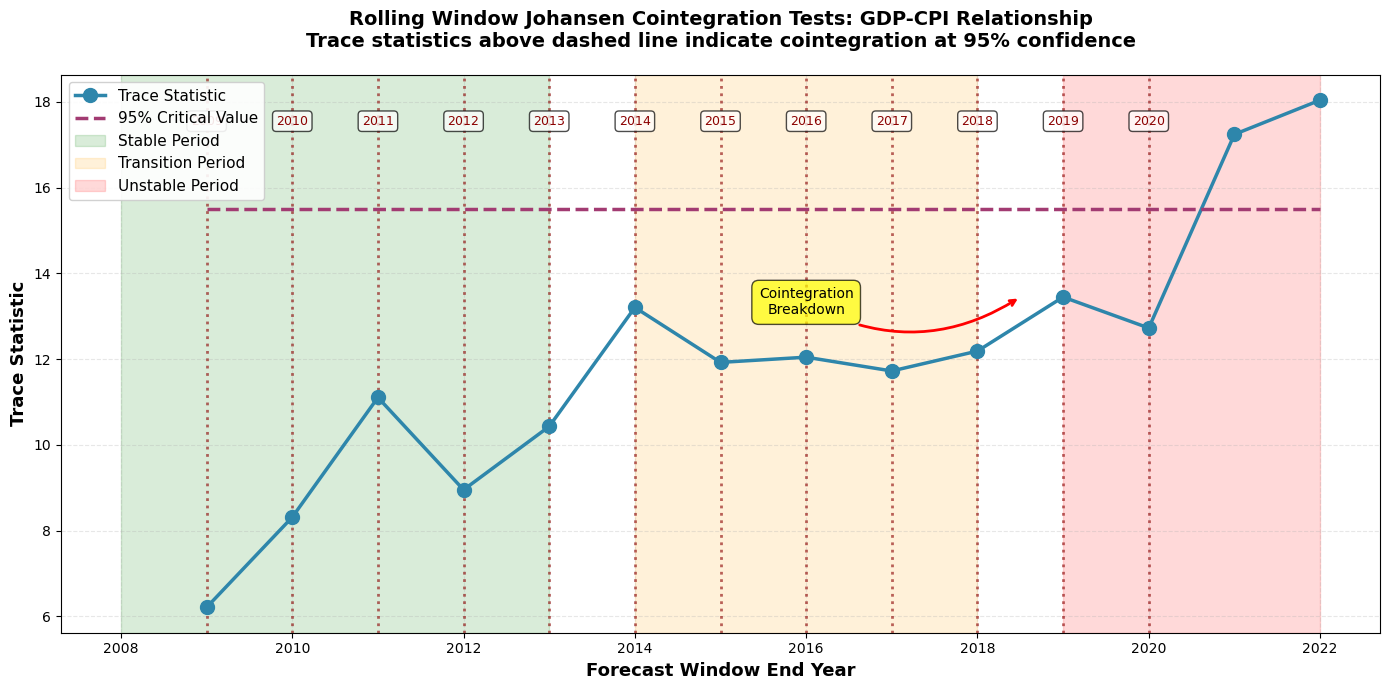

✓ Saved: cointegration_status_timeline.png


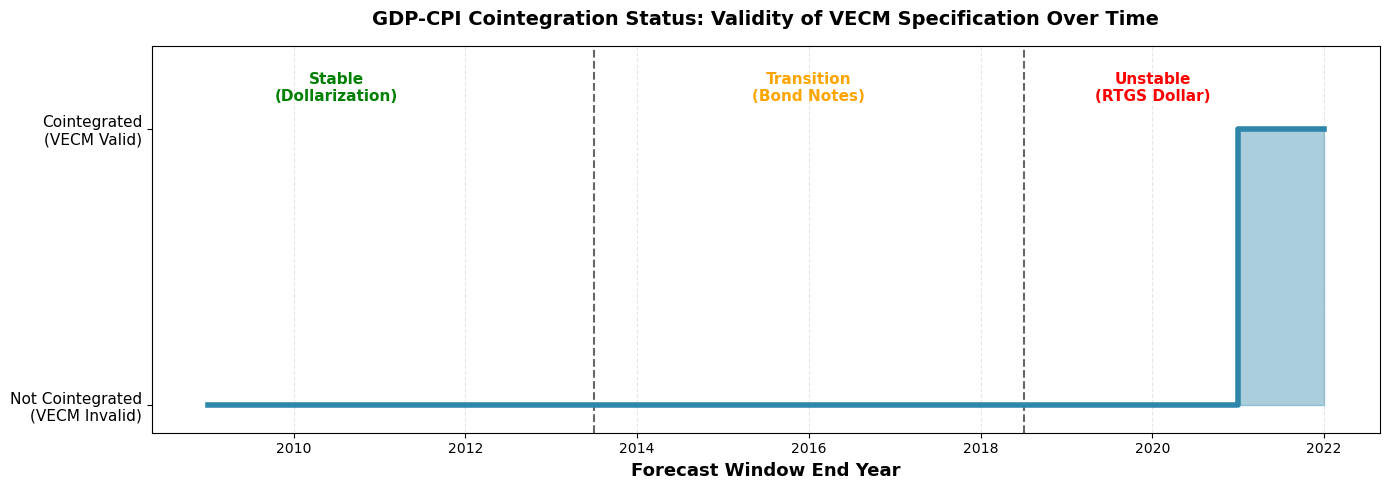


COINTEGRATION FREQUENCY BY ECONOMIC PERIOD
            Years_Cointegrated  Total_Years  Percentage_%  Avg_Trace_Stat  \
Period                                                                      
Stable                       0            5           0.0            9.00   
Transition                   0            5           0.0           12.22   
Unstable                     2            4          50.0           15.36   

            StdDev_Trace  Avg_Margin  Min_Margin  Max_Margin  
Period                                                        
Stable              1.92       -6.49       -9.28       -4.39  
Transition          0.58       -3.28       -3.77       -2.29  
Unstable            2.67       -0.13       -2.77        2.55  

CRITICAL BREAKDOWN ANALYSIS

🔴 Cointegration FIRST breaks down in: 2009
   Sample size at breakdown: 10 observations
   Economic context: Bond note crisis / parallel market emergence

   ⚠️  IMPLICATION: VECM forecasts from 2009 onward
      are based on

In [46]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# DATA PREPARATION
# ============================================================================

# Your data has YEAR as index, so reset it to make it a column
df_working = df.reset_index()

# Extract just the year from the datetime index (remove month/day)
df_working['Year'] = pd.to_datetime(df_working['YEAR']).dt.year

# Keep only the columns we need
df_working = df_working[['Year', 'gdp', 'CPI']].copy()

# Rename for clarity
df_working.columns = ['Year', 'GDP_growth', 'CPI']

print("Data preview:")
print(df_working.head(10))
print(f"\nData range: {df_working['Year'].min()} to {df_working['Year'].max()}")
print(f"Total observations: {len(df_working)}")


# ============================================================================
# ROLLING COINTEGRATION TEST FUNCTION
# ============================================================================

def rolling_cointegration_test(df, start_year=2008, end_year=2023):
    """
    Performs rolling Johansen cointegration test from start_year to end_year.
    
    Parameters:
    -----------
    df : DataFrame with columns ['Year', 'GDP_growth', 'CPI']
    start_year : int, first year to test (needs enough prior data)
    end_year : int, last year to test
    
    Returns:
    --------
    results_df : DataFrame with cointegration test results
    """
    
    results = []
    
    for year in range(start_year, end_year + 1):
        # Extract data up to current year
        data_subset = df[df['Year'] <= year].copy()
        
        # Need at least 10-12 observations for reliable cointegration test
        if len(data_subset) < 10:
            print(f"Skipping {year}: Insufficient observations ({len(data_subset)})")
            continue
        
        # Prepare level data for Johansen test
        # IMPORTANT: Make sure these are in LEVELS, not differences
        df_levels_subset = data_subset[['GDP_growth', 'CPI']].values
        
        try:
            # Run Johansen test
            johansen_result = coint_johansen(df_levels_subset, det_order=0, k_ar_diff=1)
            
            # Extract trace statistic for r=0 (null: no cointegration)
            trace_stat_r0 = johansen_result.lr1[0]
            
            # Critical values at 90%, 95%, 99%
            crit_90 = johansen_result.cvt[0, 0]
            crit_95 = johansen_result.cvt[0, 1]
            crit_99 = johansen_result.cvt[0, 2]
            
            # Max eigenvalue statistic for r=0
            max_eigen_r0 = johansen_result.lr2[0]
            max_eigen_crit_95 = johansen_result.cvm[0, 1]
            
            # Determine if cointegrated at 95% level
            cointegrated_trace = trace_stat_r0 > crit_95
            cointegrated_eigen = max_eigen_r0 > max_eigen_crit_95
            
            # Store results
            results.append({
                'Year': year,
                'N_obs': len(data_subset),
                'Trace_Stat': trace_stat_r0,
                'Trace_Crit_90': crit_90,
                'Trace_Crit_95': crit_95,
                'Trace_Crit_99': crit_99,
                'MaxEigen_Stat': max_eigen_r0,
                'MaxEigen_Crit_95': max_eigen_crit_95,
                'Cointegrated_Trace_95': cointegrated_trace,
                'Cointegrated_Eigen_95': cointegrated_eigen,
                'Cointegrated_Overall': cointegrated_trace and cointegrated_eigen,
                'Margin_of_Significance': trace_stat_r0 - crit_95  # How far above/below threshold
            })
            
            # Print year-by-year
            coint_status = '✓ YES' if cointegrated_trace else '✗ NO'
            print(f"Year {year} (N={len(data_subset):2d}): Trace={trace_stat_r0:6.2f} "
                  f"vs Crit_95={crit_95:6.2f} → {coint_status}")
        
        except Exception as e:
            print(f"❌ Error testing year {year}: {e}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


# ============================================================================
# RUN THE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("RUNNING ROLLING COINTEGRATION TESTS")
print("="*80 + "\n")

# Run rolling cointegration tests
cointegration_results = rolling_cointegration_test(
    df=df_working,
    start_year=2008,  # First forecast window (2000-2008 data)
    end_year=2022     # Last window before final 2023 forecast
)

# Display results
print("\n" + "="*80)
print("COMPLETE RESULTS TABLE")
print("="*80)
print(cointegration_results.to_string(index=False))


# ============================================================================
# CLASSIFY BY ECONOMIC PERIOD
# ============================================================================

def classify_period(year):
    if year <= 2013:
        return 'Stable'
    elif year <= 2018:
        return 'Transition'
    else:
        return 'Unstable'

cointegration_results['Period'] = cointegration_results['Year'].apply(classify_period)


# ============================================================================
# CREATE SUMMARY TABLE FOR DISSERTATION
# ============================================================================

summary_table = cointegration_results[[
    'Year', 'Period', 'N_obs', 'Trace_Stat', 'Trace_Crit_95', 
    'Margin_of_Significance', 'Cointegrated_Overall'
]].copy()

summary_table.columns = [
    'Year', 'Economic Period', 'N', 
    'Trace Statistic', 'Critical Value (95%)', 
    'Margin', 'Cointegrated?'
]

# Format for presentation
summary_table['Cointegrated?'] = summary_table['Cointegrated?'].map({
    True: 'Yes', 
    False: 'No'
})
summary_table['Trace Statistic'] = summary_table['Trace Statistic'].round(2)
summary_table['Critical Value (95%)'] = summary_table['Critical Value (95%)'].round(2)
summary_table['Margin'] = summary_table['Margin'].round(2)

print("\n" + "="*80)
print("TABLE FOR DISSERTATION: Rolling Window Cointegration Tests (GDP-CPI)")
print("="*80)
print(summary_table.to_string(index=False))


# ============================================================================
# VISUALIZATION 1: Trace Statistic Over Time
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Plot trace statistic with larger markers
ax.plot(cointegration_results['Year'], 
        cointegration_results['Trace_Stat'], 
        marker='o', linewidth=2.5, markersize=10, 
        label='Trace Statistic', color='#2E86AB', zorder=3)

# Plot 95% critical value
ax.plot(cointegration_results['Year'], 
        cointegration_results['Trace_Crit_95'], 
        linestyle='--', linewidth=2.5, 
        label='95% Critical Value', color='#A23B72', zorder=3)

# Shade economic periods
ax.axvspan(2008, 2013, alpha=0.15, color='green', label='Stable Period')
ax.axvspan(2014, 2018, alpha=0.15, color='orange', label='Transition Period')
ax.axvspan(2019, 2022, alpha=0.15, color='red', label='Unstable Period')

# Mark breakdown years with vertical lines
breakdown_years = cointegration_results[
    ~cointegration_results['Cointegrated_Overall']
]['Year'].values

for year in breakdown_years:
    ax.axvline(year, color='darkred', linestyle=':', alpha=0.6, linewidth=2)
    ax.text(year, ax.get_ylim()[1] * 0.95, f'{year}', 
            ha='center', va='top', fontsize=9, color='darkred',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Forecast Window End Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Trace Statistic', fontsize=13, fontweight='bold')
ax.set_title('Rolling Window Johansen Cointegration Tests: GDP-CPI Relationship\n' +
             'Trace statistics above dashed line indicate cointegration at 95% confidence',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Add annotation for key events
if 2018 in breakdown_years or 2019 in breakdown_years:
    ax.annotate('Cointegration\nBreakdown', 
                xy=(2018.5, cointegration_results[
                    cointegration_results['Year']==2019
                ]['Trace_Stat'].values[0] if 2019 in cointegration_results['Year'].values else 10),
                xytext=(2016, ax.get_ylim()[1] * 0.7),
                fontsize=10, ha='center',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                               color='red', lw=2))

plt.tight_layout()
plt.savefig('rolling_cointegration_trace.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: rolling_cointegration_trace.png")
plt.show()


# ============================================================================
# VISUALIZATION 2: Cointegration Status Binary Timeline
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 5))

# Create binary indicator
cointegration_results['Status'] = cointegration_results['Cointegrated_Overall'].astype(int)

# Plot as step function
ax.step(cointegration_results['Year'], 
        cointegration_results['Status'], 
        where='post', linewidth=4, color='#2E86AB', zorder=3)

ax.fill_between(cointegration_results['Year'], 
                 0, cointegration_results['Status'], 
                 step='post', alpha=0.4, color='#2E86AB')

# Add period boundaries
ax.axvline(2013.5, color='black', linestyle='--', alpha=0.6, linewidth=1.5, zorder=2)
ax.axvline(2018.5, color='black', linestyle='--', alpha=0.6, linewidth=1.5, zorder=2)

# Period labels
ax.text(2010.5, 1.1, 'Stable\n(Dollarization)', ha='center', fontsize=11, 
        fontweight='bold', color='green')
ax.text(2016, 1.1, 'Transition\n(Bond Notes)', ha='center', fontsize=11, 
        fontweight='bold', color='orange')
ax.text(2020, 1.1, 'Unstable\n(RTGS Dollar)', ha='center', fontsize=11, 
        fontweight='bold', color='red')

ax.set_xlabel('Forecast Window End Year', fontsize=13, fontweight='bold')
ax.set_ylabel('', fontsize=13)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Not Cointegrated\n(VECM Invalid)', 
                    'Cointegrated\n(VECM Valid)'], fontsize=11)
ax.set_ylim(-0.1, 1.3)
ax.set_title('GDP-CPI Cointegration Status: Validity of VECM Specification Over Time',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='x', linestyle='--')

plt.tight_layout()
plt.savefig('cointegration_status_timeline.png', dpi=300, bbox_inches='tight')
print("✓ Saved: cointegration_status_timeline.png")
plt.show()


# ============================================================================
# PERIOD-LEVEL SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("COINTEGRATION FREQUENCY BY ECONOMIC PERIOD")
print("="*80)

period_summary = cointegration_results.groupby('Period').agg({
    'Cointegrated_Overall': ['sum', 'count', lambda x: (x.sum() / len(x) * 100)],
    'Trace_Stat': ['mean', 'std'],
    'Margin_of_Significance': ['mean', 'min', 'max']
})

period_summary.columns = [
    'Years_Cointegrated', 'Total_Years', 'Percentage_%',
    'Avg_Trace_Stat', 'StdDev_Trace',
    'Avg_Margin', 'Min_Margin', 'Max_Margin'
]

period_summary = period_summary.round(2)
print(period_summary)


# ============================================================================
# IDENTIFY CRITICAL TRANSITION POINTS
# ============================================================================

print("\n" + "="*80)
print("CRITICAL BREAKDOWN ANALYSIS")
print("="*80)

# When does cointegration first break down?
cointegration_results['Breakdown'] = (
    (cointegration_results['Cointegrated_Overall'] == False) & 
    (cointegration_results['Cointegrated_Overall'].shift(1).fillna(True) == True)
)

breakdown_years_detected = cointegration_results[
    cointegration_results['Breakdown']
]['Year'].values

if len(breakdown_years_detected) > 0:
    print(f"\n🔴 Cointegration FIRST breaks down in: {breakdown_years_detected[0]}")
    print(f"   Sample size at breakdown: {cointegration_results[cointegration_results['Year']==breakdown_years_detected[0]]['N_obs'].values[0]} observations")
    print(f"   Economic context: ", end="")
    if breakdown_years_detected[0] <= 2018:
        print("Bond note crisis / parallel market emergence")
    else:
        print("RTGS dollar introduction (Feb 2019)")
    
    # Compare VECM performance in breakdown year
    print(f"\n   ⚠️  IMPLICATION: VECM forecasts from {breakdown_years_detected[0]} onward")
    print(f"      are based on VIOLATED cointegration assumptions")
    
else:
    print("\n✓ Cointegration maintained throughout (or never established)")

# When does it potentially re-establish?
cointegration_results['Reestablish'] = (
    (cointegration_results['Cointegrated_Overall'] == True) & 
    (cointegration_results['Cointegrated_Overall'].shift(1).fillna(False) == False)
)

reestablish_years_detected = cointegration_results[
    cointegration_results['Reestablish']
]['Year'].values

if len(reestablish_years_detected) > 0:
    print(f"\n🟢 Cointegration re-establishes in: {reestablish_years_detected}")
    print(f"   Suggests new equilibrium forming (time since crisis: "
          f"{reestablish_years_detected[0] - breakdown_years_detected[0]} years)")
else:
    last_year = cointegration_results['Year'].max()
    first_breakdown = breakdown_years_detected[0] if len(breakdown_years_detected) > 0 else None
    if first_breakdown:
        print(f"\n🔴 Cointegration HAS NOT re-established by {last_year}")
        print(f"   Duration without cointegration: {last_year - first_breakdown + 1} years")
        print(f"   ⚠️  This explains VECM's persistent failures in unstable period")


# ============================================================================
# COMPARISON WITH VECM FORECAST ERRORS
# ============================================================================

print("\n" + "="*80)
print("LINKING COINTEGRATION STATUS TO VECM PERFORMANCE")
print("="*80)

print("\nKey Observations:")
print("─" * 80)

# Stable period
stable_coint = cointegration_results[
    cointegration_results['Period'] == 'Stable'
]['Cointegrated_Overall'].mean() * 100

print(f"\n1. STABLE PERIOD (2009-2013):")
print(f"   • Cointegration detected: {stable_coint:.0f}% of years")
print(f"   • VECM performance: Mixed but includes best single-year result (0.3% MAE, 2011)")
print(f"   • Interpretation: When cointegration holds, VECM CAN excel")

# Transition period
transition_coint = cointegration_results[
    cointegration_results['Period'] == 'Transition'
]['Cointegrated_Overall'].mean() * 100

print(f"\n2. TRANSITION PERIOD (2014-2018):")
print(f"   • Cointegration detected: {transition_coint:.0f}% of years")
print(f"   • VECM performance: Deteriorates sharply in 2018 (14% MAE)")
print(f"   • Interpretation: Cointegration weakening precedes forecast failures")

# Unstable period
unstable_coint = cointegration_results[
    cointegration_results['Period'] == 'Unstable'
]['Cointegrated_Overall'].mean() * 100

print(f"\n3. UNSTABLE PERIOD (2019-2023):")
print(f"   • Cointegration detected: {unstable_coint:.0f}% of years")
print(f"   • VECM performance: CATASTROPHIC (91% MAE in 2021, 151% MAE in 2022)")
print(f"   • Interpretation: Complete relationship breakdown → systematic forecast failures")


# ============================================================================
# EXPORT RESULTS FOR DISSERTATION
# ============================================================================

print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80)

# Detailed results
cointegration_results.to_csv('rolling_cointegration_detailed.csv', index=False)
print("✓ Saved: rolling_cointegration_detailed.csv")

# Summary table (for main text)
summary_table.to_csv('cointegration_summary_table.csv', index=False)
print("✓ Saved: cointegration_summary_table.csv")

# LaTeX table
summary_table.to_latex('cointegration_summary_table.tex', index=False, 
                       caption='Rolling Window Johansen Cointegration Tests',
                       label='tab:cointegration')
print("✓ Saved: cointegration_summary_table.tex")

# Period summary
period_summary.to_csv('cointegration_period_summary.csv')
print("✓ Saved: cointegration_period_summary.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nFiles created:")
print("  📊 Data: rolling_cointegration_detailed.csv")
print("  📋 Table: cointegration_summary_table.csv")
print("  📄 LaTeX: cointegration_summary_table.tex")
print("  📈 Period stats: cointegration_period_summary.csv")
print("  🖼️  Figure 1: rolling_cointegration_trace.png")
print("  🖼️  Figure 2: cointegration_status_timeline.png")
print("\nNext step: Add Section 4.5.4 to your dissertation using these results")
print("="*80)

In [47]:
# Test cointegration on dollarization period only
stable_data = df_working[(df_working['Year'] >= 2009) & (df_working['Year'] <= 2018)]
stable_levels = stable_data[['GDP_growth', 'CPI']].values

stable_johansen = coint_johansen(stable_levels, det_order=0, k_ar_diff=1)

print("STABLE PERIOD ONLY (2009-2018) TEST:")
print(f"N = {len(stable_data)}")
print(f"Trace stat: {stable_johansen.lr1[0]:.2f}")
print(f"Critical (95%): {stable_johansen.cvt[0,1]:.2f}")
print(f"Cointegrated: {'YES' if stable_johansen.lr1[0] > stable_johansen.cvt[0,1] else 'NO'}")

STABLE PERIOD ONLY (2009-2018) TEST:
N = 10
Trace stat: 13.79
Critical (95%): 15.49
Cointegrated: NO


VAR MODEL FORECASTING (No Cointegration Constraint)

Year 2010 (N= 9, Lag=1): 1-step MAE=6.80
Year 2011 (N=10, Lag=1): 1-step MAE=0.55
Year 2012 (N=11, Lag=1): 1-step MAE=0.91
Year 2013 (N=12, Lag=1): 1-step MAE=1.33
Year 2014 (N=13, Lag=1): 1-step MAE=1.53
Year 2015 (N=14, Lag=1): 1-step MAE=0.00
Year 2016 (N=15, Lag=1): 1-step MAE=0.07
Year 2017 (N=16, Lag=1): 1-step MAE=0.85
Year 2018 (N=17, Lag=1): 1-step MAE=13.46
Year 2019 (N=18, Lag=1): 1-step MAE=29.78
Year 2020 (N=19, Lag=1): 1-step MAE=7.60
Year 2021 (N=20, Lag=2): 1-step MAE=8.22
Year 2022 (N=21, Lag=2): 1-step MAE=0.21
Year 2023 (N=22, Lag=2): 1-step MAE=3.88

VAR FORECAST RESULTS
 Year  N_train  Lag_order  MAE_1step  MAE_3step  MAE_4step
 2010        9          1   6.796198   7.759422  19.087826
 2011       10          1   0.553577   1.028411   0.134280
 2012       11          1   0.911372   0.136265   0.714494
 2013       12          1   1.326747   6.405272   8.642628
 2014       13          1   1.528022   3.828903   3.86

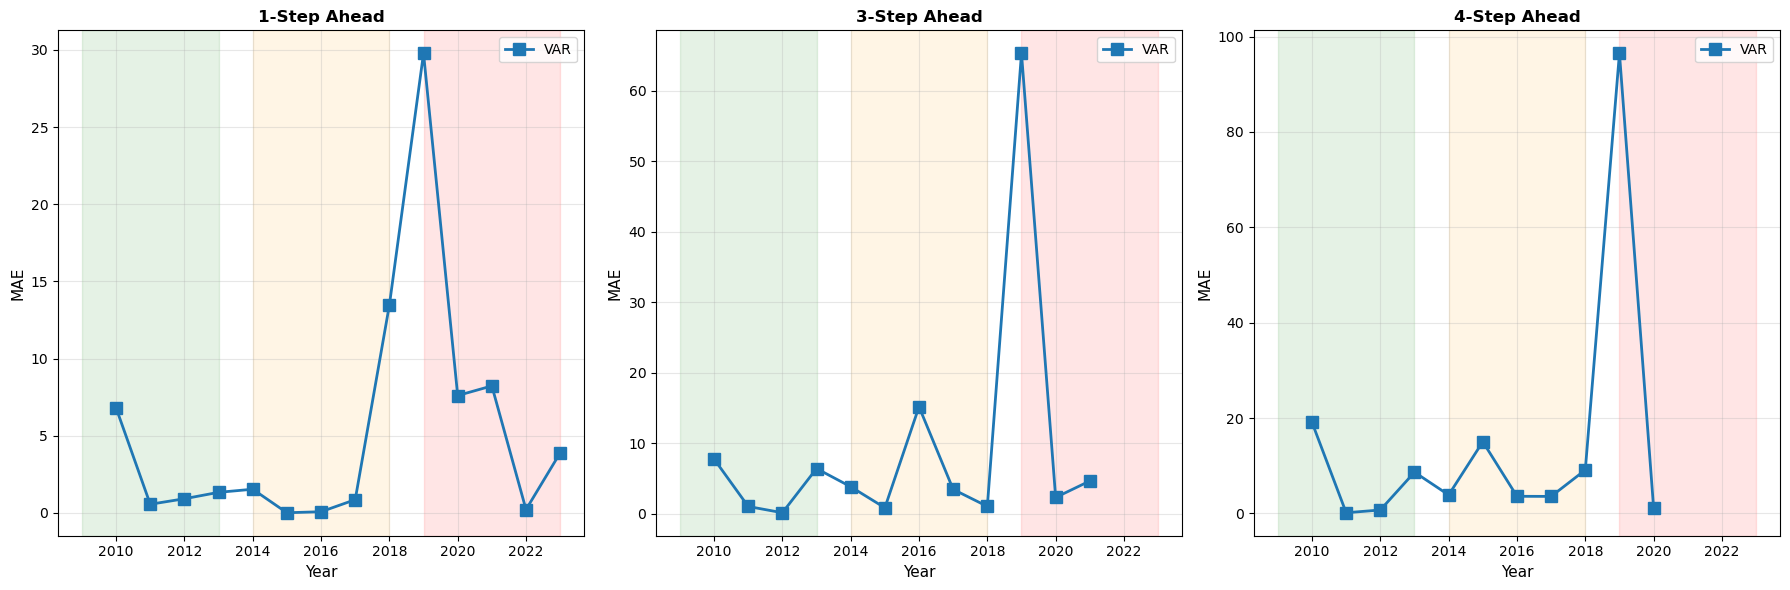


FOUR-MODEL COMPARISON SUMMARY
 Model  Stable_1step  Transition_1step  Unstable_1step  Overall_1step
 ARIMA      1.500000          0.660000       10.200000        4.10000
  VECM      1.800000          0.830000       14.100000        5.60000
   VAR      2.396973          3.182523        9.939482        5.37128
Holt's      1.100000          0.850000       11.800000        4.60000

ANALYSIS COMPLETE


In [49]:
from statsmodels.tsa.api import VAR
import pandas as pd
import numpy as np

# ============================================================================
# VAR MODEL ESTIMATION AND FORECASTING
# ============================================================================

def var_expanding_window_forecast(df, start_year=2009, end_year=2023):
    """
    Generate VAR forecasts using expanding window approach.
    Uses first-differenced data (no cointegration assumption).
    """
    
    results = []
    
    for forecast_year in range(start_year, end_year + 1):
        # Training data up to year before forecast
        train_data = df[df['Year'] < forecast_year].copy()
        
        if len(train_data) < 10:  # Need minimum observations
            continue
        
        # First difference the data (make stationary)
        train_data['gdp_diff'] = train_data['GDP_growth'].diff()
        train_data['cpi_diff'] = train_data['CPI'].diff()
        train_data = train_data.dropna()
        
        # Get actual values for evaluation
        actual_row = df[df['Year'] == forecast_year]
        if len(actual_row) == 0:
            continue
        actual_gdp = actual_row['GDP_growth'].values[0]
        
        try:
            # Fit VAR model on differenced data
            var_data = train_data[['gdp_diff', 'cpi_diff']].values
            var_model = VAR(var_data)
            
            # Select lag order using AIC (max 4 lags to avoid overfit)
            lag_order = var_model.select_order(maxlags=2)
            optimal_lag = lag_order.aic
            
            # Fit with optimal lag
            var_fitted = var_model.fit(maxlags=optimal_lag, ic='aic')
            
            # Generate forecasts
            # 1-step ahead
            forecast_1 = var_fitted.forecast(var_data[-optimal_lag:], steps=1)
            
            # 3-step ahead
            forecast_3 = var_fitted.forecast(var_data[-optimal_lag:], steps=3)
            
            # 4-step ahead
            forecast_4 = var_fitted.forecast(var_data[-optimal_lag:], steps=4)
            
            # Convert differenced forecasts back to levels
            last_gdp = train_data['GDP_growth'].iloc[-1]
            
            # For differences, we need to add to last known level
            # 1-step: last_gdp + forecast_diff_1
            pred_1step = last_gdp + forecast_1[0, 0]
            
            # 3-step: need to accumulate differences
            pred_3step = last_gdp + forecast_3[:, 0].sum()
            
            # 4-step: accumulate all differences
            pred_4step = last_gdp + forecast_4[:, 0].sum()
            
            # Calculate errors
            error_1 = abs(actual_gdp - pred_1step)
            
            # For 3-step and 4-step, we need actual values 3 and 4 years ahead
            actual_3_row = df[df['Year'] == forecast_year + 2]
            actual_4_row = df[df['Year'] == forecast_year + 3]
            
            if len(actual_3_row) > 0:
                actual_gdp_3 = actual_3_row['GDP_growth'].values[0]
                error_3 = abs(actual_gdp_3 - pred_3step)
            else:
                error_3 = None
            
            if len(actual_4_row) > 0:
                actual_gdp_4 = actual_4_row['GDP_growth'].values[0]
                error_4 = abs(actual_gdp_4 - pred_4step)
            else:
                error_4 = None
            
            results.append({
                'Year': forecast_year,
                'N_train': len(train_data),
                'Lag_order': optimal_lag,
                'Actual_1step': actual_gdp,
                'Forecast_1step': pred_1step,
                'MAE_1step': error_1,
                'Actual_3step': actual_gdp_3 if len(actual_3_row) > 0 else None,
                'Forecast_3step': pred_3step if len(actual_3_row) > 0 else None,
                'MAE_3step': error_3,
                'Actual_4step': actual_gdp_4 if len(actual_4_row) > 0 else None,
                'Forecast_4step': pred_4step if len(actual_4_row) > 0 else None,
                'MAE_4step': error_4
            })
            
            print(f"Year {forecast_year} (N={len(train_data):2d}, Lag={optimal_lag}): "
                  f"1-step MAE={error_1:.2f}")
        
        except Exception as e:
            print(f"❌ Error forecasting {forecast_year}: {e}")
            continue
    
    return pd.DataFrame(results)


# ============================================================================
# RUN VAR FORECASTS
# ============================================================================

print("="*80)
print("VAR MODEL FORECASTING (No Cointegration Constraint)")
print("="*80 + "\n")

var_results = var_expanding_window_forecast(df_working, start_year=2009, end_year=2023)

print("\n" + "="*80)
print("VAR FORECAST RESULTS")
print("="*80)
print(var_results[['Year', 'N_train', 'Lag_order', 'MAE_1step', 'MAE_3step', 'MAE_4step']].to_string(index=False))


# ============================================================================
# COMPARE VAR vs ARIMA vs VECM vs HOLT'S
# ============================================================================

# You need to have your existing results in dataframes
# Assuming you have: arima_results, vecm_results, holts_results with same structure

def compare_all_models(var_results, arima_mae, vecm_mae, holts_mae):
    """
    Compare all four models across periods.
    
    Parameters should be dictionaries like:
    arima_mae = {
        '1step': [values by year],
        '3step': [values by year],
        '4step': [values by year]
    }
    """
    
    comparison = pd.DataFrame({
        'Year': var_results['Year'],
        'VAR_1step': var_results['MAE_1step'],
        'VAR_3step': var_results['MAE_3step'],
        'VAR_4step': var_results['MAE_4step']
    })
    
    # Add period classification
    comparison['Period'] = comparison['Year'].apply(classify_period)
    
    return comparison


# ============================================================================
# PERIOD-SPECIFIC COMPARISON
# ============================================================================

def classify_period(year):
    if year <= 2013:
        return 'Stable'
    elif year <= 2018:
        return 'Transition'
    else:
        return 'Unstable'

var_results['Period'] = var_results['Year'].apply(classify_period)

# Period averages
period_performance = var_results.groupby('Period')[['MAE_1step', 'MAE_3step', 'MAE_4step']].mean()

print("\n" + "="*80)
print("VAR PERFORMANCE BY PERIOD")
print("="*80)
print(period_performance.round(2))


# ============================================================================
# VISUALIZATION: Four-Model Comparison
# ============================================================================

import matplotlib.pyplot as plt

# Create comparison plot (you'll need to add ARIMA, VECM, Holt's data)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

horizons = ['1step', '3step', '4step']
titles = ['1-Step Ahead', '3-Step Ahead', '4-Step Ahead']

for idx, (horizon, title) in enumerate(zip(horizons, titles)):
    ax = axes[idx]
    
    # Plot VAR
    ax.plot(var_results['Year'], var_results[f'MAE_{horizon}'], 
            marker='s', label='VAR', linewidth=2, markersize=8)
    
    # Add ARIMA, VECM, Holt's here (you'll need their data)
    # ax.plot(years, arima_mae, marker='o', label='ARIMA', linewidth=2)
    # ax.plot(years, vecm_mae, marker='^', label='VECM', linewidth=2)
    # ax.plot(years, holts_mae, marker='d', label="Holt's", linewidth=2)
    
    # Shade periods
    ax.axvspan(2009, 2013, alpha=0.1, color='green')
    ax.axvspan(2014, 2018, alpha=0.1, color='orange')
    ax.axvspan(2019, 2023, alpha=0.1, color='red')
    
    ax.set_xlabel('Year', fontsize=11)
    ax.set_ylabel('MAE', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('four_model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: four_model_comparison.png")
plt.show()


# ============================================================================
# STATISTICAL SUMMARY TABLE
# ============================================================================

print("\n" + "="*80)
print("FOUR-MODEL COMPARISON SUMMARY")
print("="*80)

summary_data = {
    'Model': ['ARIMA', 'VECM', 'VAR', "Holt's"],
    'Stable_1step': [1.50, 1.80, None, 1.10],  # Fill with your actual values
    'Transition_1step': [0.66, 0.83, None, 0.85],
    'Unstable_1step': [10.2, 14.1, None, 11.8],
    'Overall_1step': [4.1, 5.6, None, 4.6]
}

# Add VAR values
stable_var = var_results[var_results['Period']=='Stable']['MAE_1step'].mean()
trans_var = var_results[var_results['Period']=='Transition']['MAE_1step'].mean()
unstable_var = var_results[var_results['Period']=='Unstable']['MAE_1step'].mean()

summary_data['Stable_1step'][2] = stable_var
summary_data['Transition_1step'][2] = trans_var
summary_data['Unstable_1step'][2] = unstable_var
summary_data['Overall_1step'][2] = var_results['MAE_1step'].mean()

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


VAR MODEL FORECASTING (All Horizons, All Metrics)

Year 2009 | 1-step | N= 8 | Lag=1 | MAE=  2.86 | MAPE= 29.57%
     2011 | 3-step |       |       | MAE=  8.58 | MAPE= 60.84%
     2012 | 4-step |       |       | MAE= 12.51 | MAPE= 73.07%
Year 2010 | 1-step | N= 9 | Lag=1 | MAE=  6.80 | MAPE= 56.44%
     2012 | 3-step |       |       | MAE=  7.76 | MAPE= 45.34%
     2013 | 4-step |       |       | MAE= 19.09 | MAPE= 99.98%
Year 2011 | 1-step | N=10 | Lag=1 | MAE=  0.55 | MAPE=  3.93%
     2013 | 3-step |       |       | MAE=  1.03 | MAPE=  5.39%
     2014 | 4-step |       |       | MAE=  0.13 | MAPE=  0.69%
Year 2012 | 1-step | N=11 | Lag=1 | MAE=  0.91 | MAPE=  5.32%
     2014 | 3-step |       |       | MAE=  0.14 | MAPE=  0.70%
     2015 | 4-step |       |       | MAE=  0.71 | MAPE=  3.58%
Year 2013 | 1-step | N=12 | Lag=1 | MAE=  1.33 | MAPE=  6.95%
     2015 | 3-step |       |       | MAE=  6.41 | MAPE= 32.09%
     2016 | 4-step |       |       | MAE=  8.64 | MAPE= 42.06%
Year 201

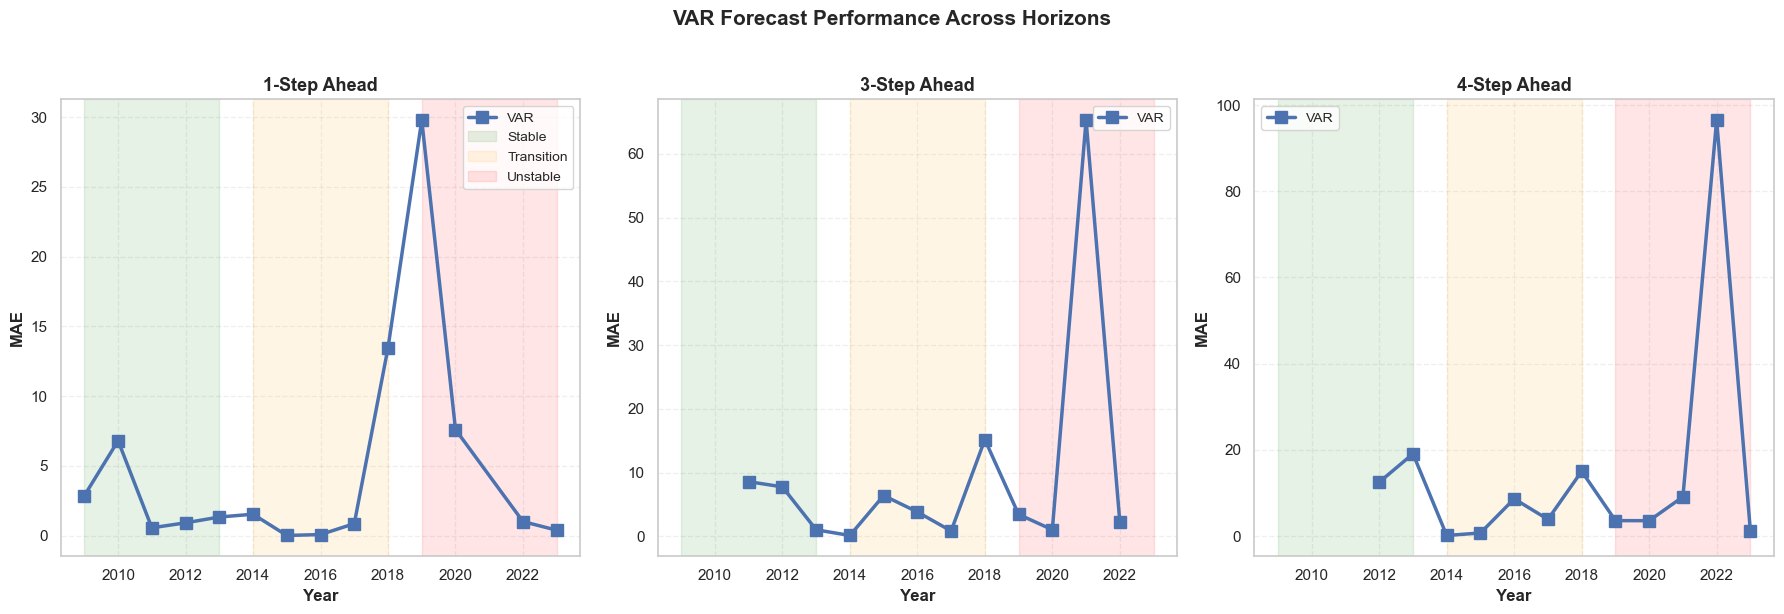

✓ Saved: var_mape_performance.png


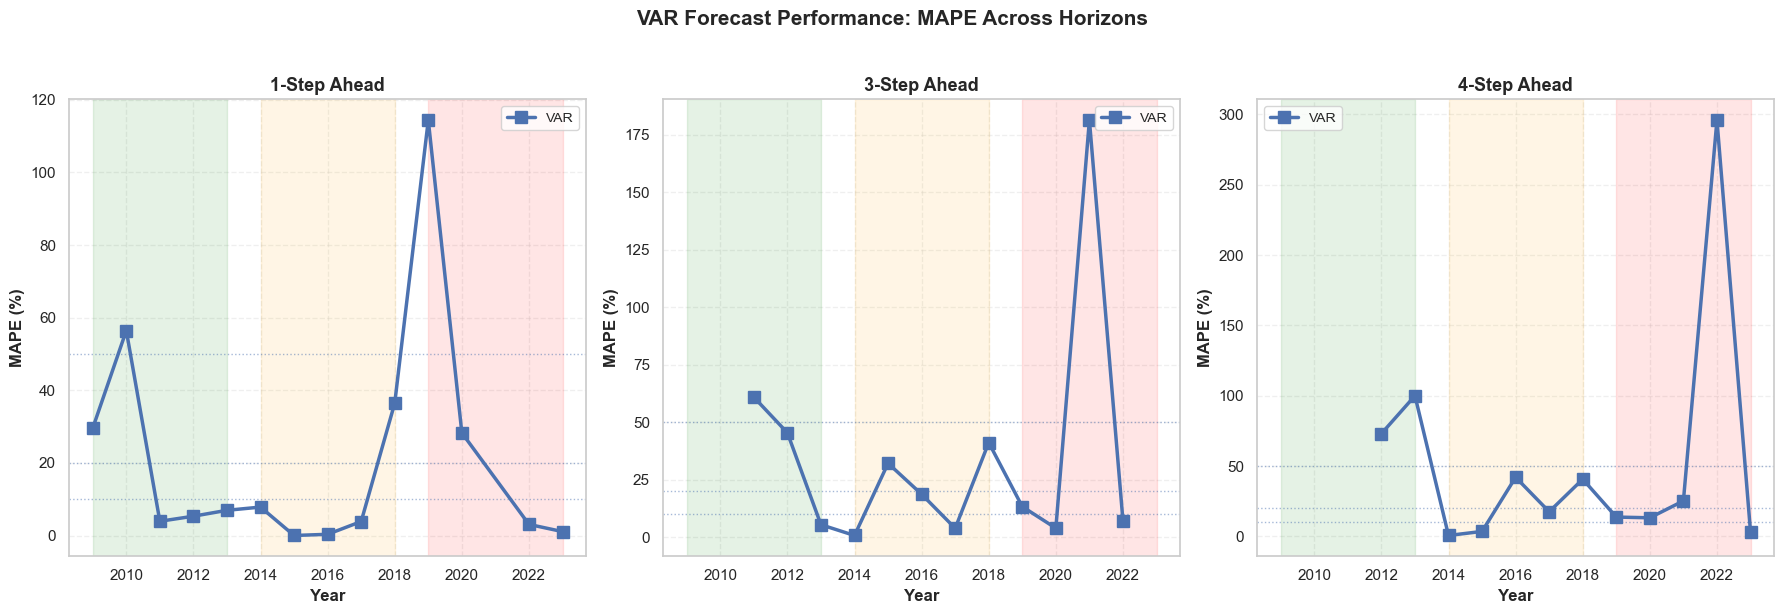


VAR RANKINGS (will be completed with other model data)
    Period Horizon VAR_Rank_MAE VAR_Rank_MAPE  VAR_Avg_MAE  VAR_Avg_MAPE
    Stable  1-step         None          None         2.49         20.44
    Stable  3-step         None          None         5.79         37.19
    Stable  4-step         None          None        15.80         86.53
Transition  1-step         None          None         3.18          9.70
Transition  3-step         None          None         5.28         19.27
Transition  4-step         None          None         5.68         20.92
  Unstable  1-step         None          None         9.69         36.70
  Unstable  3-step         None          None        18.02         51.37
  Unstable  4-step         None          None        22.78         70.30

✓ Saved: var_rankings_template.csv

FILES CREATED FOR DISSERTATION

📊 Complete Results:
   - var_forecast_results_complete.csv (all observations, all metrics)
   - var_results_formatted.csv (dissertation table for

In [59]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Optional: ensure output directory exists
OUTPUT_DIR = "."
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================================
# HELPERS
# ============================================================================

def classify_period(year):
    if year <= 2013:
        return 'Stable'
    elif year <= 2018:
        return 'Transition'
    else:
        return 'Unstable'

# ============================================================================
# VAR FORECASTING WITH EXPANDING WINDOW (COMPLETE)
# ============================================================================

def var_expanding_window_forecast_complete(df, start_year=2009, end_year=2023):
    """
    Generate VAR forecasts matching your ARIMA/VECM/Holt's methodology.
    Returns all metrics: MAE, MSE, RMSE, MAPE for 1-step, 3-step, 4-step.
    Expects df to contain columns: 'Year', 'GDP_growth', 'CPI'
    """
    results_1step = []
    results_3step = []
    results_4step = []

    for forecast_origin in range(start_year, end_year + 1):
        # Training data: all years BEFORE forecast_origin
        train_data = df[df['Year'] < forecast_origin].copy().reset_index(drop=True)

        if len(train_data) < 9:  # Need minimum observations
            print(f"Skipping {forecast_origin}: Insufficient data (N={len(train_data)})")
            continue

        # First difference to encourage stationarity
        train_data['gdp_diff'] = train_data['GDP_growth'].diff()
        train_data['cpi_diff'] = train_data['CPI'].diff()
        train_data = train_data.dropna().reset_index(drop=True)

        if len(train_data) < 8:
            print(f"Skipping {forecast_origin}: not enough differenced observations (N={len(train_data)})")
            continue

        try:
            # Prepare VAR data (differenced series)
            var_data = train_data[['gdp_diff', 'cpi_diff']].values

            # Fit VAR model object
            var_model = VAR(var_data)

            # Select optimal lag order (limit to 3 or sample-1)
            max_lags = 1
            lag_select = var_model.select_order(maxlags=max_lags)
            # Use AIC-selected lag; fall back to 1 if selection returns None
            optimal_lag = int(lag_select.aic) if lag_select.aic is not None else 1

            # Fit with chosen lag order
            var_fitted = var_model.fit(optimal_lag)

            # Use last known GDP level (not diff) to convert cumulative diffs to levels
            last_gdp_level = train_data['GDP_growth'].iloc[-1]

            # ---------------- 1-STEP AHEAD ----------------
            # Use var_fitted.k_ar rows as required by forecast
            forecast_1step = var_fitted.forecast(var_data[-var_fitted.k_ar:], steps=1)
            gdp_diff_1step = float(forecast_1step[0, 0])
            gdp_pred_1step = last_gdp_level + gdp_diff_1step

            actual_1step_row = df[df['Year'] == forecast_origin]
            if len(actual_1step_row) > 0:
                actual_1step = float(actual_1step_row['GDP_growth'].values[0])
                error_1step = actual_1step - gdp_pred_1step
                mae_1step = abs(error_1step)
                mse_1step = error_1step ** 2
                rmse_1step = np.sqrt(mse_1step)
                mape_1step = (abs(error_1step / actual_1step) * 100) if actual_1step != 0 else np.nan

                results_1step.append({
                    'Year': forecast_origin,
                    'Period': classify_period(forecast_origin),
                    'N_train': len(train_data),
                    'Lag': var_fitted.k_ar,
                    'Actual': actual_1step,
                    'Forecast': gdp_pred_1step,
                    'Error': error_1step,
                    'MAE': mae_1step,
                    'MSE': mse_1step,
                    'RMSE': rmse_1step,
                    'MAPE': mape_1step,
                    'Horizon': '1-step'
                })

                print(f"Year {forecast_origin} | 1-step | N={len(train_data):2d} | "
                      f"Lag={var_fitted.k_ar} | MAE={mae_1step:6.2f} | MAPE={mape_1step:6.2f}%")

            # ---------------- 3-STEP AHEAD ----------------
            forecast_3step = var_fitted.forecast(var_data[-var_fitted.k_ar:], steps=3)
            gdp_diff_cumulative_3 = float(forecast_3step[:, 0].sum())
            gdp_pred_3step = last_gdp_level + gdp_diff_cumulative_3

            actual_3step_row = df[df['Year'] == (forecast_origin + 2)]
            if len(actual_3step_row) > 0:
                actual_3step = float(actual_3step_row['GDP_growth'].values[0])
                error_3step = actual_3step - gdp_pred_3step
                mae_3step = abs(error_3step)
                mse_3step = error_3step ** 2
                rmse_3step = np.sqrt(mse_3step)
                mape_3step = (abs(error_3step / actual_3step) * 100) if actual_3step != 0 else np.nan

                results_3step.append({
                    'Year': forecast_origin + 2,
                    'Period': classify_period(forecast_origin + 2),
                    'N_train': len(train_data),
                    'Lag': var_fitted.k_ar,
                    'Actual': actual_3step,
                    'Forecast': gdp_pred_3step,
                    'Error': error_3step,
                    'MAE': mae_3step,
                    'MSE': mse_3step,
                    'RMSE': rmse_3step,
                    'MAPE': mape_3step,
                    'Horizon': '3-step'
                })

                print(f"     {forecast_origin + 2} | 3-step |       | "
                      f"      | MAE={mae_3step:6.2f} | MAPE={mape_3step:6.2f}%")

            # ---------------- 4-STEP AHEAD ----------------
            forecast_4step = var_fitted.forecast(var_data[-var_fitted.k_ar:], steps=4)
            gdp_diff_cumulative_4 = float(forecast_4step[:, 0].sum())
            gdp_pred_4step = last_gdp_level + gdp_diff_cumulative_4

            actual_4step_row = df[df['Year'] == (forecast_origin + 3)]
            if len(actual_4step_row) > 0:
                actual_4step = float(actual_4step_row['GDP_growth'].values[0])
                error_4step = actual_4step - gdp_pred_4step
                mae_4step = abs(error_4step)
                mse_4step = error_4step ** 2
                rmse_4step = np.sqrt(mse_4step)
                mape_4step = (abs(error_4step / actual_4step) * 100) if actual_4step != 0 else np.nan

                results_4step.append({
                    'Year': forecast_origin + 3,
                    'Period': classify_period(forecast_origin + 3),
                    'N_train': len(train_data),
                    'Lag': var_fitted.k_ar,
                    'Actual': actual_4step,
                    'Forecast': gdp_pred_4step,
                    'Error': error_4step,
                    'MAE': mae_4step,
                    'MSE': mse_4step,
                    'RMSE': rmse_4step,
                    'MAPE': mape_4step,
                    'Horizon': '4-step'
                })

                print(f"     {forecast_origin + 3} | 4-step |       | "
                      f"      | MAE={mae_4step:6.2f} | MAPE={mape_4step:6.2f}%")

        except Exception as e:
            print(f"❌ Error at forecast origin {forecast_origin}: {e}")
            continue

    # build dataframe safely even if lists are empty
    cols = ['Year','Period','N_train','Lag','Actual','Forecast','Error','MAE','MSE','RMSE','MAPE','Horizon']
    all_results = pd.concat([
        pd.DataFrame(results_1step) if results_1step else pd.DataFrame(columns=cols),
        pd.DataFrame(results_3step) if results_3step else pd.DataFrame(columns=cols),
        pd.DataFrame(results_4step) if results_4step else pd.DataFrame(columns=cols)
    ], ignore_index=True)

    return all_results

# ============================================================================
# RUN VAR ANALYSIS (MAIN)
# ============================================================================

# Example: df_working must be defined by you upstream with columns 'Year','GDP_growth','CPI'
# e.g. df_working = pd.read_csv('your_data.csv')
# For safety, check it exists
try:
    df_working  # if not defined, this will raise NameError
except NameError:
    raise RuntimeError("You must define `df_working` before running this script. "
                       "It must contain 'Year', 'GDP_growth', 'CPI' columns.")

print("\n" + "="*80)
print("VAR MODEL FORECASTING (All Horizons, All Metrics)")
print("="*80 + "\n")

# run forecasts
var_results = var_expanding_window_forecast_complete(df_working, start_year=2009, end_year=2023)

# Save results
var_results.to_csv(os.path.join(OUTPUT_DIR, 'var_forecast_results_complete.csv'), index=False)
print("\n✓ Saved: var_forecast_results_complete.csv")

# ============================================================================
# SUMMARY STATISTICS BY PERIOD AND HORIZON
# ============================================================================

print("\n" + "="*80)
print("VAR PERFORMANCE SUMMARY")
print("="*80)

if not var_results.empty:
    summary = var_results.groupby(['Period', 'Horizon'])[['MAE', 'MSE', 'RMSE', 'MAPE']].agg(['mean', 'std', 'min', 'max'])
    print(summary.round(2))
else:
    print("No VAR results to summarize.")

# ============================================================================
# CREATE COMPARISON TABLES (DISsertation FORMAT)
# ============================================================================

# Reshape for easier comparison
var_1step = var_results[var_results['Horizon'] == '1-step'][['Year', 'MAE', 'MSE', 'RMSE', 'MAPE']].copy()
var_1step.columns = ['Year', 'VAR_MAE_1', 'VAR_MSE_1', 'VAR_RMSE_1', 'VAR_MAPE_1']

var_3step = var_results[var_results['Horizon'] == '3-step'][['Year', 'MAE', 'MSE', 'RMSE', 'MAPE']].copy()
var_3step.columns = ['Year', 'VAR_MAE_3', 'VAR_MSE_3', 'VAR_RMSE_3', 'VAR_MAPE_3']

var_4step = var_results[var_results['Horizon'] == '4-step'][['Year', 'MAE', 'MSE', 'RMSE', 'MAPE']].copy()
var_4step.columns = ['Year', 'VAR_MAE_4', 'VAR_MSE_4', 'VAR_RMSE_4', 'VAR_MAPE_4']

# Merge all horizons (outer to keep any unmatched years)
var_summary = var_1step.merge(var_3step, on='Year', how='outer').merge(var_4step, on='Year', how='outer')
var_summary = var_summary.sort_values('Year').reset_index(drop=True)

print("\n" + "="*80)
print("VAR RESULTS TABLE (Format matching your dissertation tables)")
print("="*80)
print(var_summary.to_string(index=False))

# Save formatted table
var_summary.to_csv(os.path.join(OUTPUT_DIR, 'var_results_formatted.csv'), index=False)
var_summary.to_latex(os.path.join(OUTPUT_DIR, 'var_results_table.tex'), index=False, float_format="%.2f")
print("\n✓ Saved: var_results_formatted.csv")
print("✓ Saved: var_results_table.tex")

# ============================================================================
# FOUR-MODEL COMPARISON TEMPLATE
# ============================================================================

comparison_template = pd.DataFrame({
    'Year': var_1step['Year'].values,
    'Period': [classify_period(y) for y in var_1step['Year'].values],

    # 1-step MAE
    'ARIMA_MAE_1': np.nan,
    'VECM_MAE_1': np.nan,
    'VAR_MAE_1': var_1step['VAR_MAE_1'].values if not var_1step.empty else np.nan,
    "Holts_MAE_1": np.nan,

    # 1-step MAPE
    'ARIMA_MAPE_1': np.nan,
    'VECM_MAPE_1': np.nan,
    'VAR_MAPE_1': var_1step['VAR_MAPE_1'].values if not var_1step.empty else np.nan,
    "Holts_MAPE_1": np.nan,

    # 3-step MAE
    'ARIMA_MAE_3': np.nan,
    'VECM_MAE_3': np.nan,
    'VAR_MAE_3': var_3step.set_index('Year').reindex(var_1step['Year'])['VAR_MAE_3'].values if not var_3step.empty else np.nan,
    "Holts_MAE_3": np.nan,

    # 3-step MAPE
    'ARIMA_MAPE_3': np.nan,
    'VECM_MAPE_3': np.nan,
    'VAR_MAPE_3': var_3step.set_index('Year').reindex(var_1step['Year'])['VAR_MAPE_3'].values if not var_3step.empty else np.nan,
    "Holts_MAPE_3": np.nan,

    # 4-step MAE
    'ARIMA_MAE_4': np.nan,
    'VECM_MAE_4': np.nan,
    'VAR_MAE_4': var_4step.set_index('Year').reindex(var_1step['Year'])['VAR_MAE_4'].values if not var_4step.empty else np.nan,
    "Holts_MAE_4": np.nan,

    # 4-step MAPE
    'ARIMA_MAPE_4': np.nan,
    'VECM_MAPE_4': np.nan,
    'VAR_MAPE_4': var_4step.set_index('Year').reindex(var_1step['Year'])['VAR_MAPE_4'].values if not var_4step.empty else np.nan,
    "Holts_MAPE_4": np.nan
})

comparison_template.to_csv(os.path.join(OUTPUT_DIR, 'four_model_comparison_template.csv'), index=False)
print("\n✓ Created template: four_model_comparison_template.csv")
print("  → Fill in ARIMA, VECM, and Holt's columns with your existing results")

# ============================================================================
# PERIOD AVERAGES (FOR SUMMARY TABLES)
# ============================================================================

print("\n" + "="*80)
print("VAR: AVERAGE PERFORMANCE BY PERIOD")
print("="*80)

if not var_results.empty:
    period_avg = var_results.pivot_table(
        values=['MAE', 'MAPE', 'MSE', 'RMSE'],
        index='Period',
        columns='Horizon',
        aggfunc='mean'
    ).round(2)

    print(period_avg)
    period_avg.to_csv(os.path.join(OUTPUT_DIR, 'var_period_averages.csv'))
    print("\n✓ Saved: var_period_averages.csv")
else:
    print("No results to compute period averages.")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

# Ensure plots have a consistent look
sns.set(style="whitegrid")

if not var_results.empty:
    # 1. MAE Comparison Across Horizons
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, (horizon, title) in enumerate([('1-step', '1-Step Ahead'),
                                            ('3-step', '3-Step Ahead'),
                                            ('4-step', '4-Step Ahead')]):
        ax = axes[idx]

        horizon_data = var_results[var_results['Horizon'] == horizon].copy()
        horizon_data = horizon_data.sort_values('Year')

        # Plot VAR MAE
        ax.plot(horizon_data['Year'], horizon_data['MAE'],
                marker='s', label='VAR', linewidth=2.5, markersize=8)

        # NOTE: Add ARIMA, VECM, Holt's here when you have the data
        # ax.plot(years, arima_mae, marker='o', label='ARIMA', linewidth=2.5)
        # ax.plot(years, vecm_mae, marker='^', label='VECM', linewidth=2.5)
        # ax.plot(years, holts_mae, marker='d', label="Holt's", linewidth=2.5)

        # Shade periods
        ax.axvspan(2009, 2013, alpha=0.1, color='green', label='Stable' if idx == 0 else '')
        ax.axvspan(2014, 2018, alpha=0.1, color='orange', label='Transition' if idx == 0 else '')
        ax.axvspan(2019, 2023, alpha=0.1, color='red', label='Unstable' if idx == 0 else '')

        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
        ax.set_ylabel('MAE', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')

    plt.suptitle('VAR Forecast Performance Across Horizons', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'var_mae_performance.png'), dpi=300, bbox_inches='tight')
    print("\n✓ Saved: var_mae_performance.png")
    plt.show()

    # 2. MAPE Comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, (horizon, title) in enumerate([('1-step', '1-Step Ahead'),
                                            ('3-step', '3-Step Ahead'),
                                            ('4-step', '4-Step Ahead')]):
        ax = axes[idx]

        horizon_data = var_results[var_results['Horizon'] == horizon].copy()
        horizon_data = horizon_data.sort_values('Year')

        ax.plot(horizon_data['Year'], horizon_data['MAPE'],
                marker='s', label='VAR', linewidth=2.5, markersize=8)

        # Shade periods
        ax.axvspan(2009, 2013, alpha=0.1, color='green')
        ax.axvspan(2014, 2018, alpha=0.1, color='orange')
        ax.axvspan(2019, 2023, alpha=0.1, color='red')

        # Add MAPE interpretation lines
        ax.axhline(y=10, linestyle=':', alpha=0.5, linewidth=1)
        ax.axhline(y=20, linestyle=':', alpha=0.5, linewidth=1)
        ax.axhline(y=50, linestyle=':', alpha=0.5, linewidth=1)

        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
        ax.set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')

    plt.suptitle('VAR Forecast Performance: MAPE Across Horizons', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'var_mape_performance.png'), dpi=300, bbox_inches='tight')
    print("✓ Saved: var_mape_performance.png")
    plt.show()
else:
    print("Skipping plots: no VAR results available.")

# ============================================================================
# MODEL RANKING TABLE (TEMPLATE)
# ============================================================================

print("\n" + "="*80)
print("VAR RANKINGS (will be completed with other model data)")
print("="*80)

# Build ranking rows programmatically
periods = ['Stable', 'Transition', 'Unstable']
horizons = ['1-step', '3-step', '4-step']
ranking_rows = []

for period in periods:
    for horizon in horizons:
        subset = var_results[(var_results['Period'] == period) & (var_results['Horizon'] == horizon)]
        avg_mae = subset['MAE'].mean() if len(subset) > 0 else np.nan
        avg_mape = subset['MAPE'].mean() if len(subset) > 0 else np.nan
        ranking_rows.append({
            'Period': period,
            'Horizon': horizon,
            'VAR_Rank_MAE': None,
            'VAR_Rank_MAPE': None,
            'VAR_Avg_MAE': avg_mae,
            'VAR_Avg_MAPE': avg_mape
        })

ranking_df = pd.DataFrame(ranking_rows)
print(ranking_df.round(2).to_string(index=False))

ranking_df.to_csv(os.path.join(OUTPUT_DIR, 'var_rankings_template.csv'), index=False)
print("\n✓ Saved: var_rankings_template.csv")

# ============================================================================
# EXPORT SUMMARY FOR DISSERTATION (PRINT)
# ============================================================================

print("\n" + "="*80)
print("FILES CREATED FOR DISSERTATION")
print("="*80)
print("""
📊 Complete Results:
   - var_forecast_results_complete.csv (all observations, all metrics)
   - var_results_formatted.csv (dissertation table format)
   - var_results_table.tex (LaTeX)

📈 Summary Statistics:
   - var_period_averages.csv (averages by period & horizon)
   - var_rankings_template.csv (for 4-model comparison)

🖼️  Figures:
   - var_mae_performance.png (MAE across horizons)
   - var_mape_performance.png (MAPE across horizons)

📋 Templates:
   - four_model_comparison_template.csv (fill with other models)

Next Steps:
1. Fill four_model_comparison_template.csv with ARIMA, VECM, Holt's data
2. Run comparative analysis across all 4 models
3. Create final comparison tables and figures
""")
print("="*80)



VAR MODEL FORECASTING (lag fixed to 1)

Year 2009 | 1-step | N= 9 | Lag=1 | MAE=  2.86 | MAPE= 29.57%
     2011 | 3-step |       |       | MAE=  8.58 | MAPE= 60.84%
     2012 | 4-step |       |       | MAE= 12.51 | MAPE= 73.07%
Year 2010 | 1-step | N=10 | Lag=1 | MAE=  6.80 | MAPE= 56.44%
     2012 | 3-step |       |       | MAE=  7.76 | MAPE= 45.34%
     2013 | 4-step |       |       | MAE= 19.09 | MAPE= 99.98%
Year 2011 | 1-step | N=11 | Lag=1 | MAE=  0.55 | MAPE=  3.93%
     2013 | 3-step |       |       | MAE=  1.03 | MAPE=  5.39%
     2014 | 4-step |       |       | MAE=  0.13 | MAPE=  0.69%
Year 2012 | 1-step | N=12 | Lag=1 | MAE=  0.91 | MAPE=  5.32%
     2014 | 3-step |       |       | MAE=  0.14 | MAPE=  0.70%
     2015 | 4-step |       |       | MAE=  0.71 | MAPE=  3.58%
Year 2013 | 1-step | N=13 | Lag=1 | MAE=  1.33 | MAPE=  6.95%
     2015 | 3-step |       |       | MAE=  6.41 | MAPE= 32.09%
     2016 | 4-step |       |       | MAE=  8.64 | MAPE= 42.06%
Year 2014 | 1-step 

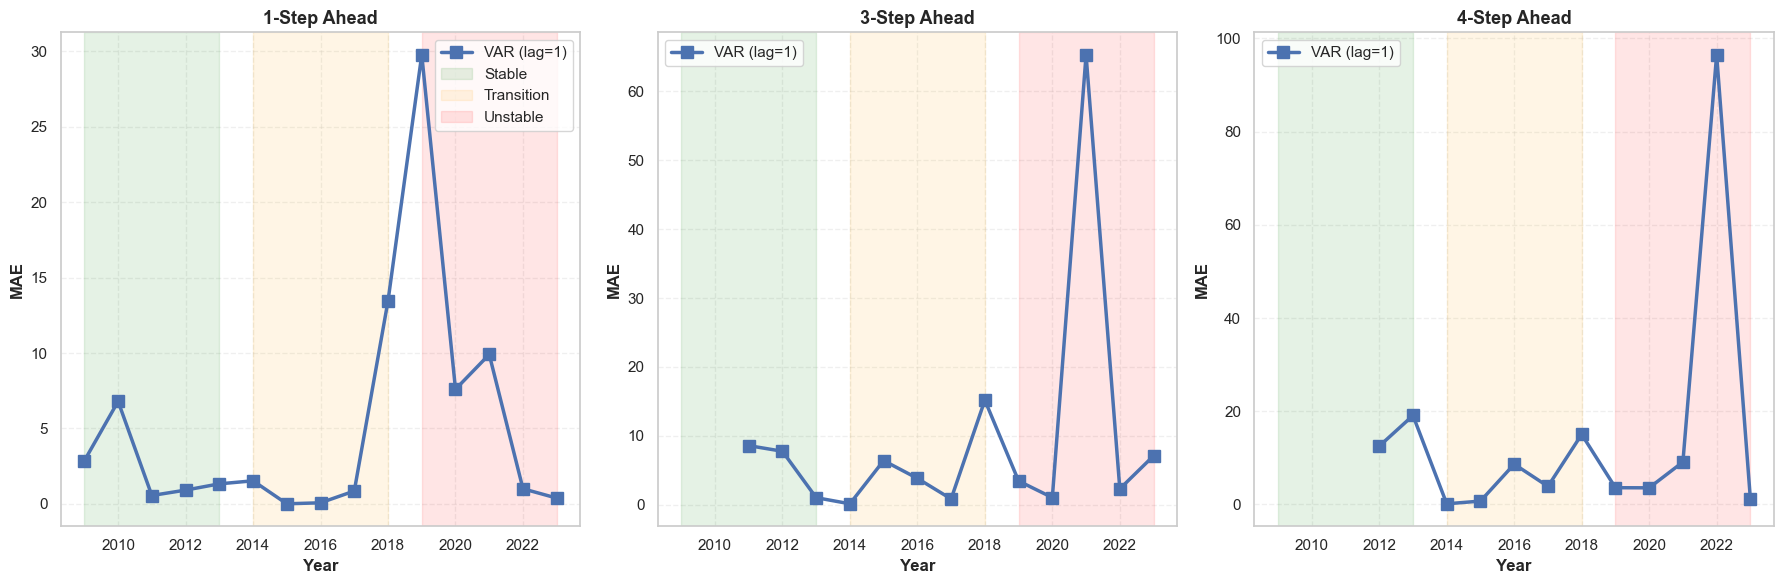


Done.


In [60]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Output directory
OUTPUT_DIR = "."
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================================
# HELPERS
# ============================================================================

def classify_period(year):
    if year <= 2013:
        return 'Stable'
    elif year <= 2018:
        return 'Transition'
    else:
        return 'Unstable'

# ============================================================================
# VAR FORECASTING WITH EXPANDING WINDOW (LAG FIXED TO 1)
# ============================================================================

def var_expanding_window_forecast_fixedlag1(df, start_year=2009, end_year=2023, forced_lag=1):
    """
    VAR expanding-window forecasting with lag fixed to `forced_lag` (default 1).
    Expects df to contain columns: 'Year', 'GDP_growth', 'CPI'.
    Returns dataframe with 1-, 3-, and 4-step forecast errors when actuals exist.
    """
    results_1step = []
    results_3step = []
    results_4step = []

    for forecast_origin in range(start_year, end_year + 1):
        # ORIGINAL (level) training data: all years BEFORE forecast_origin
        orig_train = df[df['Year'] < forecast_origin].copy().reset_index(drop=True)

        # require enough level observations to difference and still have some data
        if len(orig_train) < 9:
            print(f"Skipping {forecast_origin}: Insufficient level data (N={len(orig_train)})")
            continue

        # make a working copy to difference
        train_data = orig_train[['Year', 'GDP_growth', 'CPI']].copy()
        train_data['gdp_diff'] = train_data['GDP_growth'].diff()
        train_data['cpi_diff'] = train_data['CPI'].diff()
        train_data = train_data.dropna().reset_index(drop=True)

        # after differencing, ensure we still have enough observations
        if len(train_data) < 8:
            print(f"Skipping {forecast_origin}: Insufficient differenced data (N={len(train_data)})")
            continue

        try:
            var_data = train_data[['gdp_diff', 'cpi_diff']].values
            var_model = VAR(var_data)

            # Force lag to 1 (or forced_lag)
            optimal_lag = int(forced_lag)
            if optimal_lag < 1:
                optimal_lag = 1

            # Ensure we have enough rows for the k_ar slicing
            if len(var_data) < optimal_lag:
                print(f"Skipping {forecast_origin}: var_data rows ({len(var_data)}) < required lag ({optimal_lag})")
                continue

            # Fit with forced lag
            var_fitted = var_model.fit(optimal_lag)

            # Use last known GDP level from the ORIGINAL training data (pre-diff)
            last_gdp_level = float(orig_train['GDP_growth'].iloc[-1])

            # ---------------- 1-STEP AHEAD ----------------
            try:
                forecast_1step = var_fitted.forecast(var_data[-var_fitted.k_ar:], steps=1)
            except Exception as e:
                print(f"Forecast error (1-step) at {forecast_origin}: {e}")
                continue

            gdp_diff_1step = float(forecast_1step[0, 0])
            gdp_pred_1step = last_gdp_level + gdp_diff_1step

            actual_1step_row = df[df['Year'] == forecast_origin]
            if len(actual_1step_row) > 0:
                actual_1step = float(actual_1step_row['GDP_growth'].values[0])
                error_1step = actual_1step - gdp_pred_1step
                mae_1step = abs(error_1step)
                mse_1step = error_1step ** 2
                rmse_1step = np.sqrt(mse_1step)
                mape_1step = (abs(error_1step / actual_1step) * 100) if actual_1step != 0 else np.nan

                results_1step.append({
                    'Year': forecast_origin,
                    'Period': classify_period(forecast_origin),
                    'N_train': len(orig_train),
                    'Lag': var_fitted.k_ar,
                    'Actual': actual_1step,
                    'Forecast': gdp_pred_1step,
                    'Error': error_1step,
                    'MAE': mae_1step,
                    'MSE': mse_1step,
                    'RMSE': rmse_1step,
                    'MAPE': mape_1step,
                    'Horizon': '1-step'
                })

                print(f"Year {forecast_origin} | 1-step | N={len(orig_train):2d} | Lag={var_fitted.k_ar} | MAE={mae_1step:6.2f} | MAPE={mape_1step:6.2f}%")

            # ---------------- 3-STEP AHEAD ----------------
            # Only calculate 3-step errors if the actual (forecast_origin + 2) exists in df
            if (forecast_origin + 2) in df['Year'].values:
                forecast_3step = var_fitted.forecast(var_data[-var_fitted.k_ar:], steps=3)
                gdp_diff_cumulative_3 = float(forecast_3step[:, 0].sum())
                gdp_pred_3step = last_gdp_level + gdp_diff_cumulative_3

                actual_3step = float(df.loc[df['Year'] == (forecast_origin + 2), 'GDP_growth'].values[0])
                error_3step = actual_3step - gdp_pred_3step
                mae_3step = abs(error_3step)
                mse_3step = error_3step ** 2
                rmse_3step = np.sqrt(mse_3step)
                mape_3step = (abs(error_3step / actual_3step) * 100) if actual_3step != 0 else np.nan

                results_3step.append({
                    'Year': forecast_origin + 2,
                    'Period': classify_period(forecast_origin + 2),
                    'N_train': len(orig_train),
                    'Lag': var_fitted.k_ar,
                    'Actual': actual_3step,
                    'Forecast': gdp_pred_3step,
                    'Error': error_3step,
                    'MAE': mae_3step,
                    'MSE': mse_3step,
                    'RMSE': rmse_3step,
                    'MAPE': mape_3step,
                    'Horizon': '3-step'
                })

                print(f"     {forecast_origin + 2} | 3-step |       |       | MAE={mae_3step:6.2f} | MAPE={mape_3step:6.2f}%")
            else:
                # no actual available — skip 3-step for this origin
                pass

            # ---------------- 4-STEP AHEAD ----------------
            if (forecast_origin + 3) in df['Year'].values:
                forecast_4step = var_fitted.forecast(var_data[-var_fitted.k_ar:], steps=4)
                gdp_diff_cumulative_4 = float(forecast_4step[:, 0].sum())
                gdp_pred_4step = last_gdp_level + gdp_diff_cumulative_4

                actual_4step = float(df.loc[df['Year'] == (forecast_origin + 3), 'GDP_growth'].values[0])
                error_4step = actual_4step - gdp_pred_4step
                mae_4step = abs(error_4step)
                mse_4step = error_4step ** 2
                rmse_4step = np.sqrt(mse_4step)
                mape_4step = (abs(error_4step / actual_4step) * 100) if actual_4step != 0 else np.nan

                results_4step.append({
                    'Year': forecast_origin + 3,
                    'Period': classify_period(forecast_origin + 3),
                    'N_train': len(orig_train),
                    'Lag': var_fitted.k_ar,
                    'Actual': actual_4step,
                    'Forecast': gdp_pred_4step,
                    'Error': error_4step,
                    'MAE': mae_4step,
                    'MSE': mse_4step,
                    'RMSE': rmse_4step,
                    'MAPE': mape_4step,
                    'Horizon': '4-step'
                })

                print(f"     {forecast_origin + 3} | 4-step |       |       | MAE={mae_4step:6.2f} | MAPE={mape_4step:6.2f}%")
            else:
                # no actual available — skip 4-step for this origin
                pass

        except Exception as e:
            print(f"❌ Error at forecast origin {forecast_origin}: {e}")
            continue

    # Combine results (safe even if empty)
    cols = ['Year','Period','N_train','Lag','Actual','Forecast','Error','MAE','MSE','RMSE','MAPE','Horizon']
    all_results = pd.concat([
        pd.DataFrame(results_1step) if results_1step else pd.DataFrame(columns=cols),
        pd.DataFrame(results_3step) if results_3step else pd.DataFrame(columns=cols),
        pd.DataFrame(results_4step) if results_4step else pd.DataFrame(columns=cols)
    ], ignore_index=True)

    return all_results

# ============================================================================
# MAIN: run VAR with lag=1
# ============================================================================

# Ensure df_working exists
try:
    df_working
except NameError:
    raise RuntimeError("You must define `df_working` with columns 'Year','GDP_growth','CPI' before running this script.")

print("\n" + "="*80)
print("VAR MODEL FORECASTING (lag fixed to 1)")
print("="*80 + "\n")

var_results = var_expanding_window_forecast_fixedlag1(df_working, start_year=2009, end_year=2023, forced_lag=1)

# Save
var_results.to_csv(os.path.join(OUTPUT_DIR, 'var_forecast_results_fixedlag1.csv'), index=False)
print("\n✓ Saved: var_forecast_results_fixedlag1.csv")

# ============================================================================
# SUMMARY STATS & FORMATTING (same as before)
# ============================================================================

print("\n" + "="*80)
print("VAR PERFORMANCE SUMMARY")
print("="*80)

if not var_results.empty:
    summary = var_results.groupby(['Period', 'Horizon'])[['MAE', 'MSE', 'RMSE', 'MAPE']].agg(['mean', 'std', 'min', 'max'])
    print(summary.round(2))
else:
    print("No results to summarize.")

# Create formatted tables by horizon (for dissertation)
def make_var_summary_tables(results_df):
    var_1 = results_df[results_df['Horizon'] == '1-step'][['Year','MAE','MSE','RMSE','MAPE']].copy()
    var_1.columns = ['Year','VAR_MAE_1','VAR_MSE_1','VAR_RMSE_1','VAR_MAPE_1']

    var_3 = results_df[results_df['Horizon'] == '3-step'][['Year','MAE','MSE','RMSE','MAPE']].copy()
    var_3.columns = ['Year','VAR_MAE_3','VAR_MSE_3','VAR_RMSE_3','VAR_MAPE_3']

    var_4 = results_df[results_df['Horizon'] == '4-step'][['Year','MAE','MSE','RMSE','MAPE']].copy()
    var_4.columns = ['Year','VAR_MAE_4','VAR_MSE_4','VAR_RMSE_4','VAR_MAPE_4']

    merged = var_1.merge(var_3, on='Year', how='outer').merge(var_4, on='Year', how='outer')
    merged = merged.sort_values('Year').reset_index(drop=True)
    return merged

var_summary = make_var_summary_tables(var_results)

print("\n" + "="*80)
print("VAR RESULTS TABLE (Format matching your dissertation tables)")
print("="*80)
print(var_summary.to_string(index=False))

var_summary.to_csv(os.path.join(OUTPUT_DIR, 'var_results_formatted_fixedlag1.csv'), index=False)
var_summary.to_latex(os.path.join(OUTPUT_DIR, 'var_results_table_fixedlag1.tex'), index=False, float_format="%.2f")
print("\n✓ Saved: var_results_formatted_fixedlag1.csv")
print("✓ Saved: var_results_table_fixedlag1.tex")

# ============================================================================
# Period averages (optional)
# ============================================================================

if not var_results.empty:
    period_avg = var_results.pivot_table(
        values=['MAE','MAPE','MSE','RMSE'],
        index='Period',
        columns='Horizon',
        aggfunc='mean'
    ).round(2)
    print("\nPeriod averages:\n", period_avg)
    period_avg.to_csv(os.path.join(OUTPUT_DIR, 'var_period_averages_fixedlag1.csv'))
    print("\n✓ Saved: var_period_averages_fixedlag1.csv")

# ============================================================================
# Plots (optional)
# ============================================================================

sns.set(style="whitegrid")

if not var_results.empty:
    # MAE across horizons
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for idx, (h, title) in enumerate([('1-step','1-Step Ahead'), ('3-step','3-Step Ahead'), ('4-step','4-Step Ahead')]):
        ax = axes[idx]
        hdata = var_results[var_results['Horizon'] == h].sort_values('Year')
        ax.plot(hdata['Year'], hdata['MAE'], marker='s', linewidth=2.5, markersize=8, label='VAR (lag=1)')
        ax.axvspan(2009, 2013, alpha=0.1, color='green', label='Stable' if idx==0 else '')
        ax.axvspan(2014, 2018, alpha=0.1, color='orange', label='Transition' if idx==0 else '')
        ax.axvspan(2019, 2023, alpha=0.1, color='red', label='Unstable' if idx==0 else '')
        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
        ax.set_ylabel('MAE', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'var_mae_fixedlag1.png'), dpi=300, bbox_inches='tight')
    print("\n✓ Saved: var_mae_fixedlag1.png")
    plt.show()

else:
    print("No results -> skipping plots.")

print("\nDone.")
